In [125]:
from yaml import load, Loader
import pandas as pd
from util.analysis_utils import get_all_results, merge_results_patients, prep_patients_df, plot_exps, boxplot_sex_dice, boxplot_ethn_dice
from util.classes import EXPERIMENTS, SEEDS, ETHNICITIES
from scipy import stats

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
og_df = pd.read_csv('/vol/aimspace/projects/ukbb/data/tabular/ukb668815_imaging.csv')
patients_df = prep_patients_df(og_df)

/tmp/ipykernel_3944/1831496144.py:1: DtypeWarning: Columns (20,68,1186,1187,1188,1258,1259,1260,1552,2745,2746,2747,2748,2749,2750,2751,2752,2753,2754,2755,2756,2757,2758,2759,2760,2761,2762,2763,2764,2765,2766,2767,2768,2769,2770,2771,2772,2773,2774,2775,2776,2777,2778,2779,2780,2781,2782,2783,2784,2785,2786,2787,2788,2789,2790,2791,2792,2793,2794,2795,2796,2797,2856,2857,2858,2859,2860,2861,2862,2863,2864,2865,2866,2867,2868,2869,2870,2871,2872,2873,2874,2875,2876,2877,2878,2879,2880,2881,2882,2883,2884,2885,2886,2887,2888,2889,2890,2891,2892,2893,2894,2895,2896,2897,2898,2899,2900,2901,2902,2903,2904,2905,2906,2907,2908,2909,2910,2911,2912,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986,2987,2988,2989,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999,3000,3001,3002,3003,3004,3005,3006,3007,3008,3009,3010,3011,3012,3013,3014,3015,3016,3017,3018,3019,3020,3021,3022,3023,3024,3025,3084,3085,3086,3087,3088,3089,3090,3091,3092,3093,3094,3095,3096,3097,3098,3099,3100

# Experiments
## Sex Controlled Test Set Results

In [23]:
columns = [
    'experiment', 'model', 'train_set', 'test_set',
    'dice_mean', 'dice_lv', 'dice_rv', 'dice_myo', 
    'male', 'male_lv', 'male_rv', 'male_myo',
    'female', 'female_lv', 'female_rv', 'female_myo',
    'white', 'white_rv', 'white_lv', 'white_myo',
    'asian', 'asian_rv', 'asian_lv', 'asian_myo',
    'black', 'black_rv', 'black_lv', 'black_myo',
    'white_male', 'asian_male', 'black_male',
    'white_female', 'asian_female', 'black_female',
    'low_scores_prcnt'
]

sex_df = pd.DataFrame(columns=columns)

for exp in EXPERIMENTS:
    cfg = load(open(f'configs/ukbb/test/exp{exp}/sex.yaml', 'r'), Loader=Loader)
    for seed in SEEDS:
        test_sex_df = pd.read_csv(f'outputs/results/csv/ukbb/exp{exp}/seed{seed}/sex.csv')
        test_sex_merged_df = merge_results_patients(test_sex_df, patients_df)
        res_df = get_all_results(test_sex_merged_df, cfg)
        sex_df = pd.concat([sex_df, res_df], ignore_index=True)

/tmp/ipykernel_3944/3424907609.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sex_df = pd.concat([sex_df, res_df], ignore_index=True)


In [24]:
sex_df.head()

,experiment,model,train_set,test_set,dice_mean,dice_lv,dice_rv,dice_myo,male,male_lv,...,black_rv,black_lv,black_myo,white_male,asian_male,black_male,white_female,asian_female,black_female,low_scores_prcnt
0,2,unimatch unet,805,962,87.152064,91.591529,84.868635,84.996027,87.224825,91.634144,...,82.814604,90.430938,82.273665,87.479160,86.089401,85.611500,87.234722,86.444895,85.974055,6.484953
1,2,unimatch unet,805,962,86.939519,91.127248,84.737929,84.953381,87.050456,91.369345,...,81.829699,87.689635,81.892197,87.437771,85.185802,84.802549,86.982152,86.051054,85.929836,7.037785
2,2,unimatch unet,805,962,86.984155,91.120098,84.928500,84.903868,87.138131,91.380949,...,82.048568,88.643421,81.442047,87.451185,85.777236,85.095837,86.995262,86.114783,85.645019,7.081050
3,2,unimatch unet,805,962,86.908528,91.215736,84.528242,84.981606,86.916770,91.287981,...,81.259320,88.780807,83.536692,87.236641,85.319017,85.149366,87.064480,86.045097,86.084044,7.032978
4,2,unimatch unet,805,962,87.245658,91.459576,85.212491,85.064906,87.265935,91.509128,...,83.051359,90.564093,82.674998,87.566697,85.908766,85.380426,87.407072,86.460232,86.032819,6.470532


# Sex Groups Overall Mean DICE

In [140]:
def ttest(df, g1, g2, cls1, cls2):
    g1_dice = df[df['experiment'] == g1][cls1]
    g2_dice = df[df['experiment'] == g2][cls2]
    t_statistic, p_value = stats.ttest_ind(g1_dice, g2_dice)

    print("t-statistic:", t_statistic)
    print("p-value:", p_value)

    if p_value < 0.05:
        print(f'There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group {g1} {cls1} and {g2} {cls2}.')
    else:
        print(f'There is not sufficient evidence (p-value >= 0.05) to conclude a statistically significant difference in DICE similarity scores between experiment/group {g1} {cls1} and {g2} {cls2}.')
    print()


def sex_ttest(df, cls=''):
    for exp in EXPERIMENTS:
        print(f'Experiment {exp}')
        print('-------------')
        ttest(df, exp, exp, 'male' + cls, 'female' + cls)


def ethn_ttest(df, cls=''):
    for exp in EXPERIMENTS:
        print(f'Experiment {exp}')
        print('-------------')
        ttest(df, exp, exp, 'white' + cls, 'asian' + cls)
        ttest(df, exp, exp, 'white' + cls, 'black' + cls)
        ttest(df, exp, exp, 'asian' + cls, 'black' + cls)


classes = [
    'dice_mean', 'dice_lv', 'dice_rv', 'dice_myo', 
    'male', 'male_lv', 'male_rv', 'male_myo',
    'female', 'female_lv', 'female_rv', 'female_myo',
    'white', 'white_rv', 'white_lv', 'white_myo',
    'asian', 'asian_rv', 'asian_lv', 'asian_myo',
    'black', 'black_rv', 'black_lv', 'black_myo',
    'white_male', 'asian_male', 'black_male',
    'white_female', 'asian_female', 'black_female',
    'low_scores_prcnt'
]


def exps_ttest(df):
    for cls in classes:
        print(f'Comparing {cls}')
        print('Experiment 2 vs. 3')
        print('-------------')
        ttest(df, 2, 3, cls, cls)

        print('Experiment 2 vs. 4')
        print('-------------')
        ttest(df, 2, 4, cls, cls)
        
        print('Experiment 3 vs. 4')
        print('-------------')
        ttest(df, 3, 4, cls, cls)
        print('-----------------------------------------------------------------')


def sub_ttest(df):
    for exp in EXPERIMENTS:
        print(f'Experiment {exp}')
        for ethn in ETHNICITIES:
            print(f'{ethn}_male vs. {ethn}_female')
            ttest(sex_df, exp, exp, f'{ethn}_male', f'{ethn}_female')
        print('-------------')
        

In [97]:
sex_ttest(sex_df)

Experiment 2
-------------
t-statistic: 1.899041009722548
p-value: 0.07370742049961712
There is not sufficient evidence (p-value >= 0.05) to conclude a statistically significant difference in Dice similarity scores between experiment/group 2 male and 2 female.

Experiment 3
-------------
t-statistic: 2.0211620424505785
p-value: 0.058391436525059355
There is not sufficient evidence (p-value >= 0.05) to conclude a statistically significant difference in Dice similarity scores between experiment/group 3 male and 3 female.

Experiment 4
-------------
t-statistic: 1.1812432767693757
p-value: 0.2528788130181956
There is not sufficient evidence (p-value >= 0.05) to conclude a statistically significant difference in Dice similarity scores between experiment/group 4 male and 4 female.



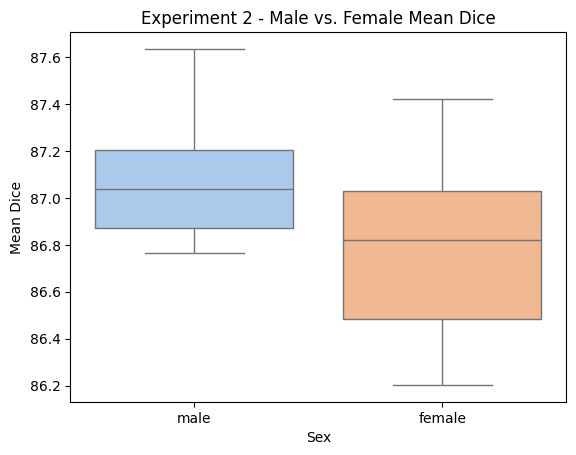

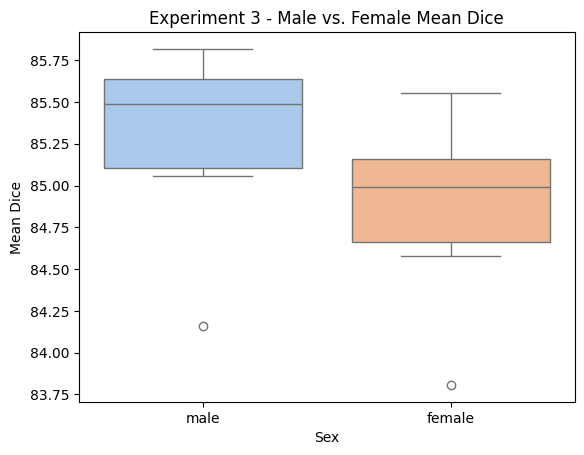

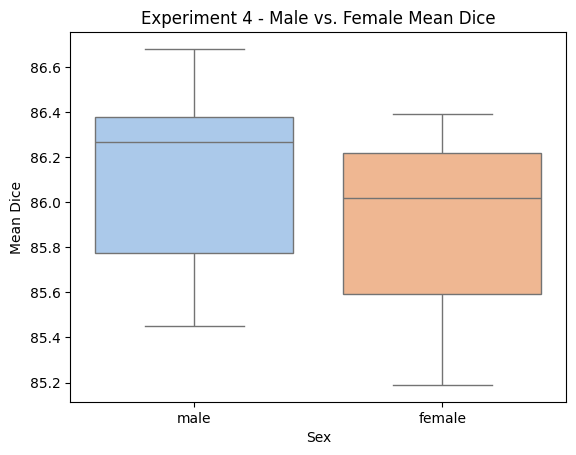

In [7]:
boxplot_sex_dice(sex_df)

# Sex Groups RV Mean DICE

In [99]:
sex_ttest(sex_df, '_rv')

Experiment 2
-------------
t-statistic: -3.0257716147129945
p-value: 0.007266218969196142
There is a statistically significant difference (p-value < 0.05) in Dice similarity scores between experiment/group 2 male_rv and 2 female_rv.

Experiment 3
-------------
t-statistic: -3.2208171223597963
p-value: 0.0047404124812299685
There is a statistically significant difference (p-value < 0.05) in Dice similarity scores between experiment/group 3 male_rv and 3 female_rv.

Experiment 4
-------------
t-statistic: -2.2593355027056568
p-value: 0.036503718531061234
There is a statistically significant difference (p-value < 0.05) in Dice similarity scores between experiment/group 4 male_rv and 4 female_rv.



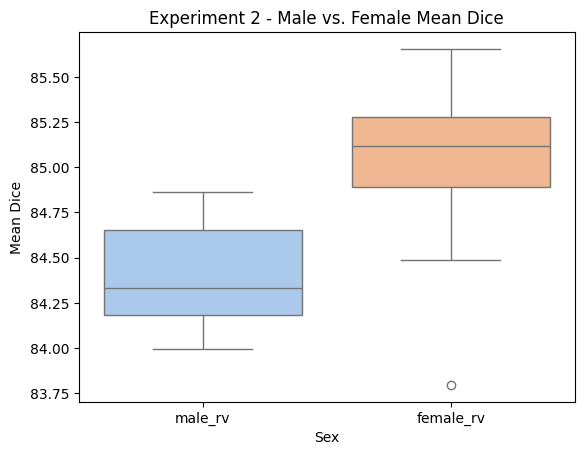

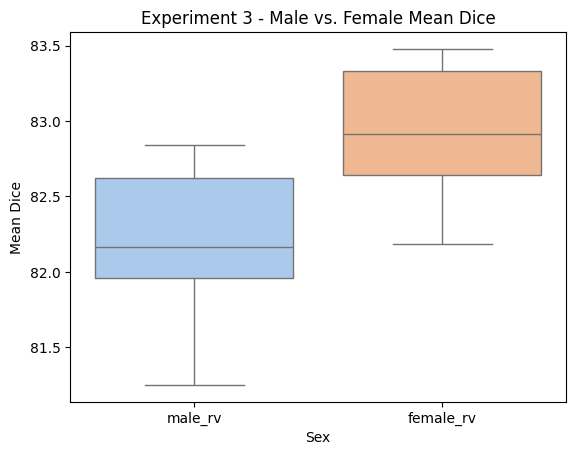

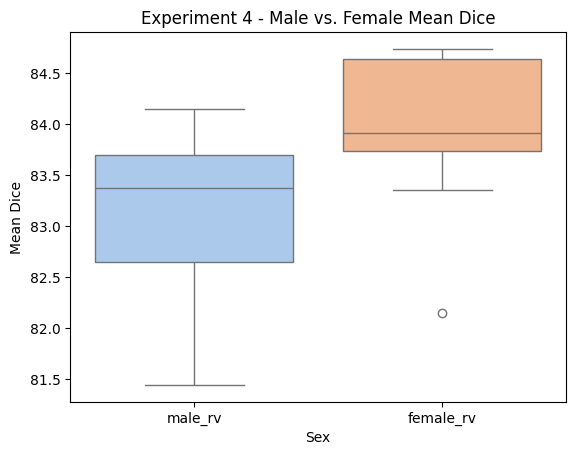

In [101]:
boxplot_sex_dice(sex_df, '_rv')

# Sex Groups LV Mean DICE

In [100]:
sex_ttest(sex_df, '_lv')

Experiment 2
-------------
t-statistic: 3.43322781704187
p-value: 0.002964979073420947
There is a statistically significant difference (p-value < 0.05) in Dice similarity scores between experiment/group 2 male_lv and 2 female_lv.

Experiment 3
-------------
t-statistic: 2.8874146272889467
p-value: 0.009808286739861363
There is a statistically significant difference (p-value < 0.05) in Dice similarity scores between experiment/group 3 male_lv and 3 female_lv.

Experiment 4
-------------
t-statistic: 2.5495850709226757
p-value: 0.02011721183283333
There is a statistically significant difference (p-value < 0.05) in Dice similarity scores between experiment/group 4 male_lv and 4 female_lv.



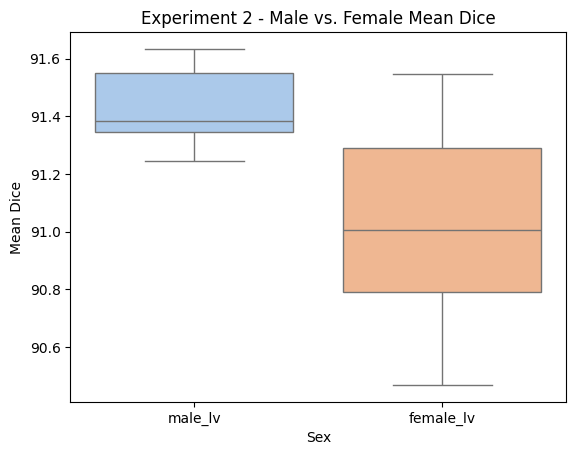

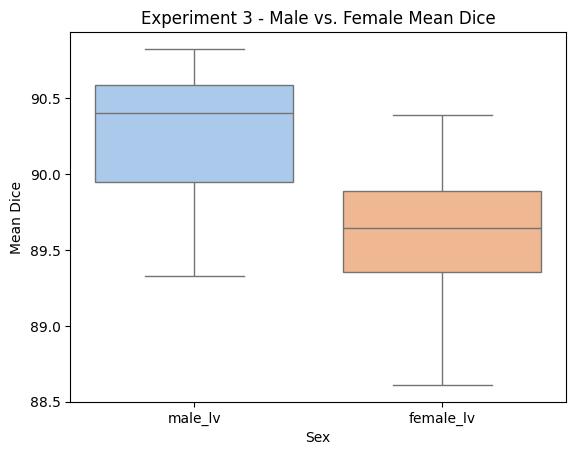

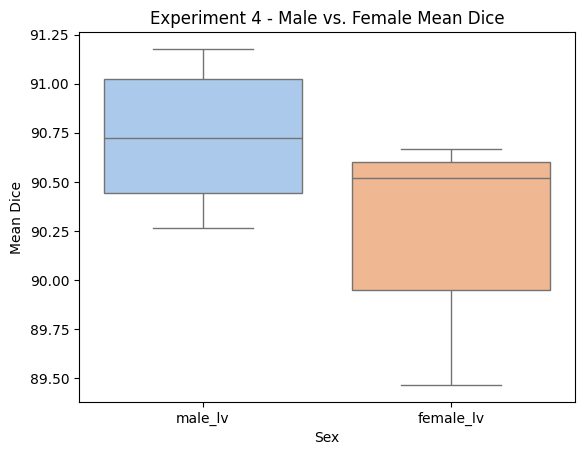

In [102]:
boxplot_sex_dice(sex_df, '_lv')

# Sex Groups MYO Mean DICE

In [102]:
sex_ttest(sex_df, '_myo')

Experiment 2
-------------
t-statistic: 4.449136561371057
p-value: 0.00030990992419032364
There is a statistically significant difference (p-value < 0.05) in Dice similarity scores between experiment/group 2 male_myo and 2 female_myo.

Experiment 3
-------------
t-statistic: 4.52032279923361
p-value: 0.00026486106980949285
There is a statistically significant difference (p-value < 0.05) in Dice similarity scores between experiment/group 3 male_myo and 3 female_myo.

Experiment 4
-------------
t-statistic: 5.270516371971381
p-value: 5.1891371957312934e-05
There is a statistically significant difference (p-value < 0.05) in Dice similarity scores between experiment/group 4 male_myo and 4 female_myo.



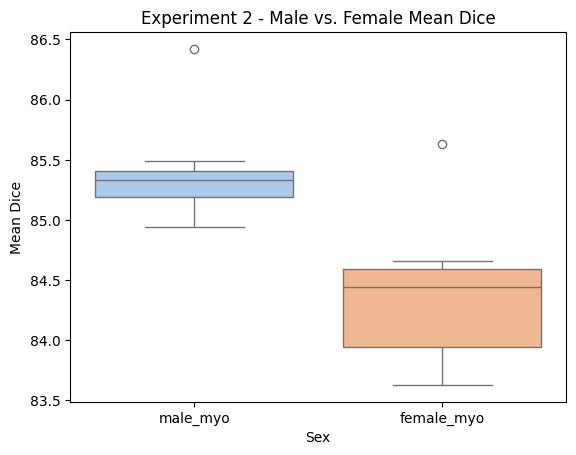

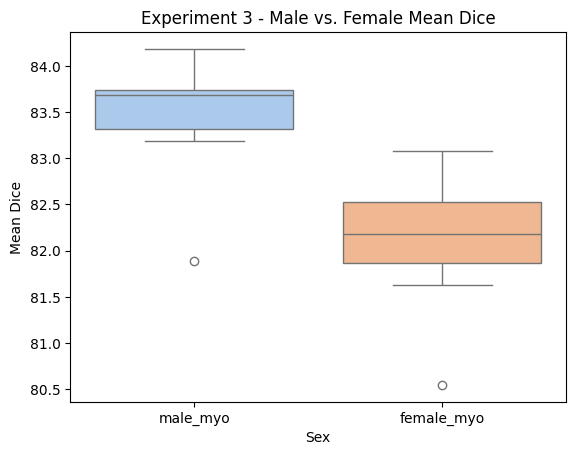

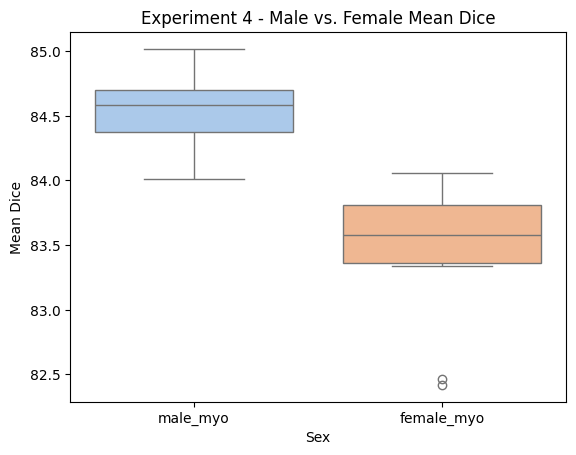

In [103]:
boxplot_sex_dice(sex_df, '_myo')

# Ethnicity Groups Overall DICE

In [103]:
ethn_ttest(sex_df)

Experiment 2
-------------
t-statistic: 5.510840988577404
p-value: 3.115678235895818e-05
There is a statistically significant difference (p-value < 0.05) in Dice similarity scores between experiment/group 2 white and 2 asian.

t-statistic: 9.21381079454336
p-value: 3.100715667538084e-08
There is a statistically significant difference (p-value < 0.05) in Dice similarity scores between experiment/group 2 white and 2 black.

t-statistic: 5.160897060274838
p-value: 6.56256842079675e-05
There is a statistically significant difference (p-value < 0.05) in Dice similarity scores between experiment/group 2 asian and 2 black.

Experiment 3
-------------
t-statistic: 4.783802087305406
p-value: 0.00014855990390630268
There is a statistically significant difference (p-value < 0.05) in Dice similarity scores between experiment/group 3 white and 3 asian.

t-statistic: 5.008724444402708
p-value: 9.110518798565587e-05
There is a statistically significant difference (p-value < 0.05) in Dice similarity s

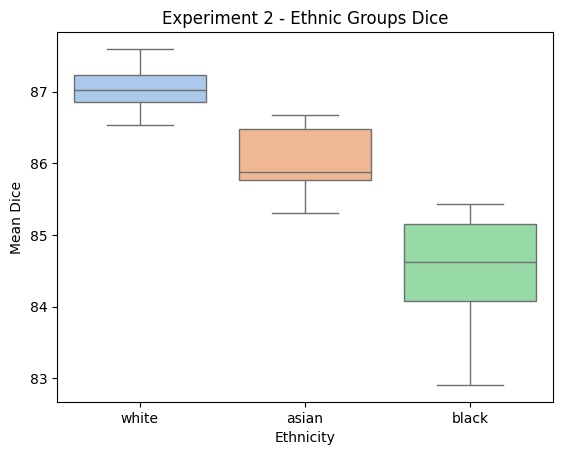

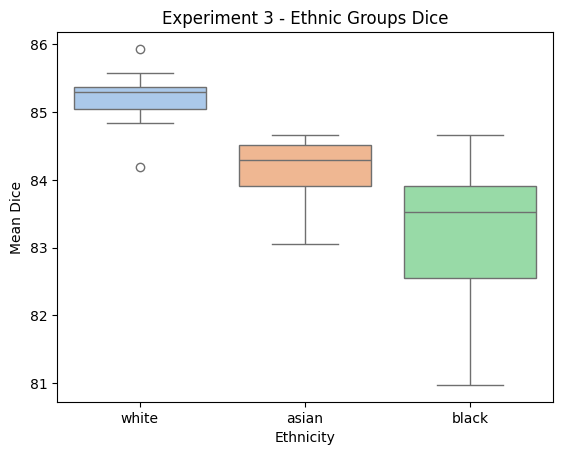

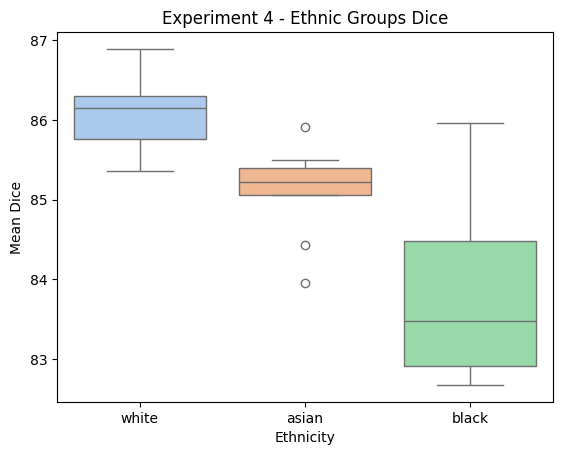

In [104]:
boxplot_ethn_dice(sex_df)

In [104]:
ethn_ttest(sex_df, '_rv')

Experiment 2
-------------
t-statistic: -1.9016234366449893
p-value: 0.0733496808613416
There is not sufficient evidence (p-value >= 0.05) to conclude a statistically significant difference in Dice similarity scores between experiment/group 2 white_rv and 2 asian_rv.

t-statistic: 6.587793008809398
p-value: 3.4593458020020985e-06
There is a statistically significant difference (p-value < 0.05) in Dice similarity scores between experiment/group 2 white_rv and 2 black_rv.

t-statistic: 7.4863389899132855
p-value: 6.22287778773871e-07
There is a statistically significant difference (p-value < 0.05) in Dice similarity scores between experiment/group 2 asian_rv and 2 black_rv.

Experiment 3
-------------
t-statistic: -2.0029263846425946
p-value: 0.06048010102338109
There is not sufficient evidence (p-value >= 0.05) to conclude a statistically significant difference in Dice similarity scores between experiment/group 3 white_rv and 3 asian_rv.

t-statistic: 2.538410594354369
p-value: 0.020592

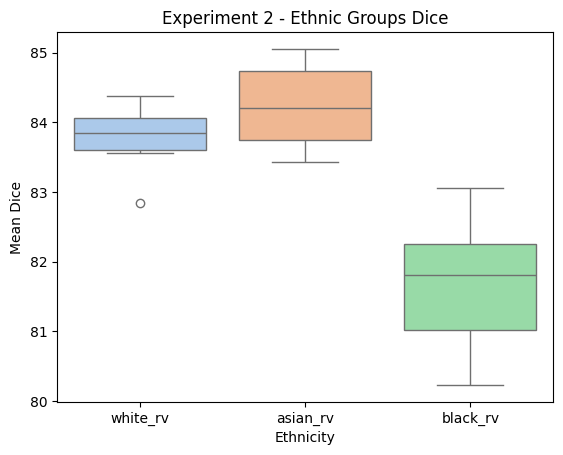

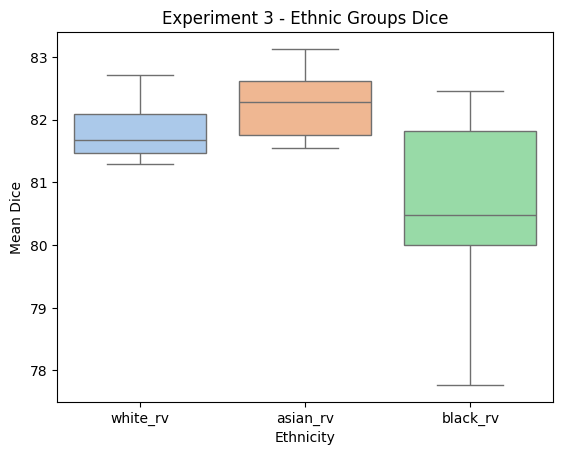

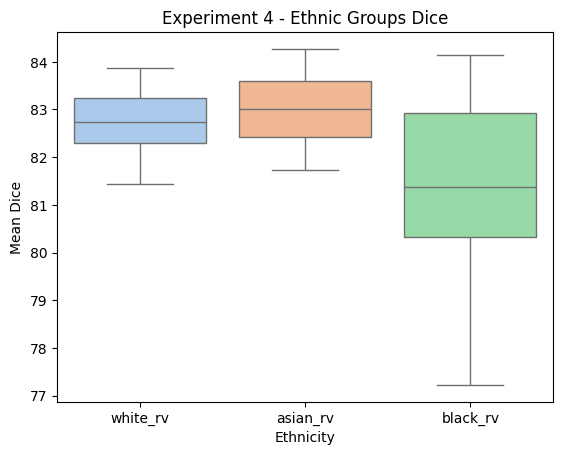

In [105]:
boxplot_ethn_dice(sex_df, '_rv')

In [105]:
ethn_ttest(sex_df, '_lv')

Experiment 2
-------------
t-statistic: 10.36984029977356
p-value: 5.092449855820692e-09
There is a statistically significant difference (p-value < 0.05) in Dice similarity scores between experiment/group 2 white_lv and 2 asian_lv.

t-statistic: 4.398308927355346
p-value: 0.00034675826408146136
There is a statistically significant difference (p-value < 0.05) in Dice similarity scores between experiment/group 2 white_lv and 2 black_lv.

t-statistic: 0.9557945903945914
p-value: 0.3518376174764898
There is not sufficient evidence (p-value >= 0.05) to conclude a statistically significant difference in Dice similarity scores between experiment/group 2 asian_lv and 2 black_lv.

Experiment 3
-------------
t-statistic: 7.527232380048756
p-value: 5.770503747251676e-07
There is a statistically significant difference (p-value < 0.05) in Dice similarity scores between experiment/group 3 white_lv and 3 asian_lv.

t-statistic: 4.209739341478311
p-value: 0.0005267001882507291
There is a statistically

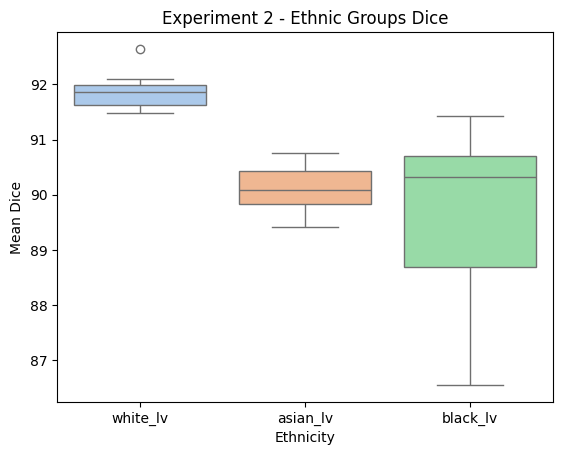

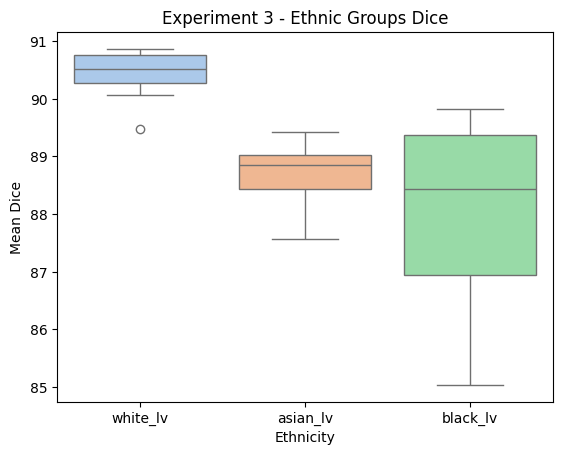

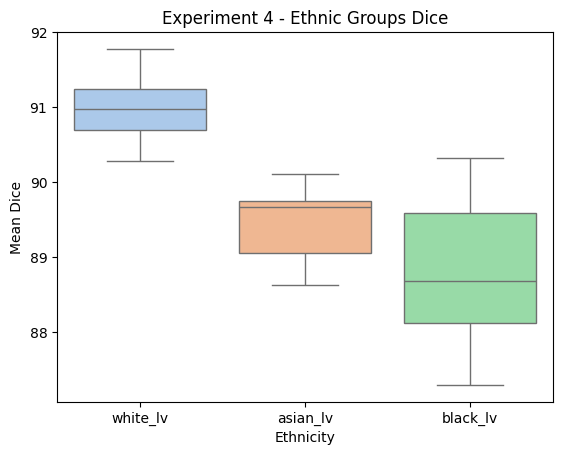

In [106]:
boxplot_ethn_dice(sex_df, '_lv')

In [106]:
ethn_ttest(sex_df, '_myo')

Experiment 2
-------------
t-statistic: 7.374909259967146
p-value: 7.652469034402373e-07
There is a statistically significant difference (p-value < 0.05) in Dice similarity scores between experiment/group 2 white_myo and 2 asian_myo.

t-statistic: 11.689055519206912
p-value: 7.691933321289273e-10
There is a statistically significant difference (p-value < 0.05) in Dice similarity scores between experiment/group 2 white_myo and 2 black_myo.

t-statistic: 4.864956381867589
p-value: 0.0001244655416348858
There is a statistically significant difference (p-value < 0.05) in Dice similarity scores between experiment/group 2 asian_myo and 2 black_myo.

Experiment 3
-------------
t-statistic: 5.907281063593406
p-value: 1.3634265048855243e-05
There is a statistically significant difference (p-value < 0.05) in Dice similarity scores between experiment/group 3 white_myo and 3 asian_myo.

t-statistic: 4.971580340696652
p-value: 9.873499438727892e-05
There is a statistically significant difference (p

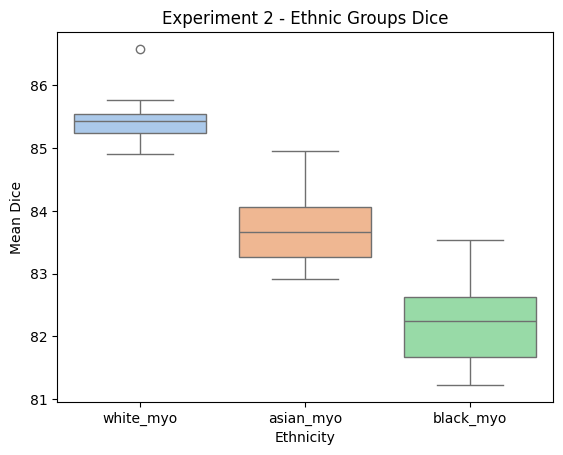

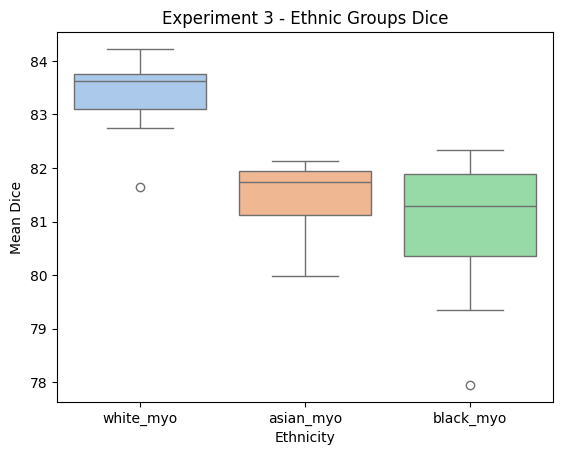

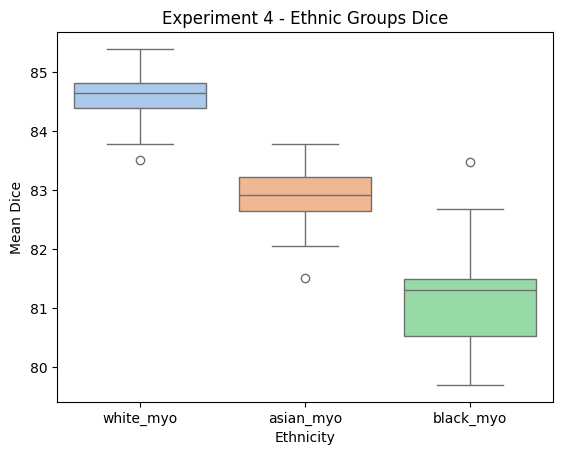

In [107]:
boxplot_ethn_dice(sex_df, '_myo')

In [107]:
ethn_ttest(sex_df, '_male')

Experiment 2
-------------
t-statistic: 11.874583690300929
p-value: 5.975398369323544e-10
There is a statistically significant difference (p-value < 0.05) in Dice similarity scores between experiment/group 2 white_male and 2 asian_male.

t-statistic: 14.783099788172587
p-value: 1.6443718393495712e-11
There is a statistically significant difference (p-value < 0.05) in Dice similarity scores between experiment/group 2 white_male and 2 black_male.

t-statistic: 2.0305610261773452
p-value: 0.05734046675365264
There is not sufficient evidence (p-value >= 0.05) to conclude a statistically significant difference in Dice similarity scores between experiment/group 2 asian_male and 2 black_male.

Experiment 3
-------------
t-statistic: 7.539906657725208
p-value: 5.637344835812091e-07
There is a statistically significant difference (p-value < 0.05) in Dice similarity scores between experiment/group 3 white_male and 3 asian_male.

t-statistic: 7.2322509814218
p-value: 9.996383188539126e-07
There i

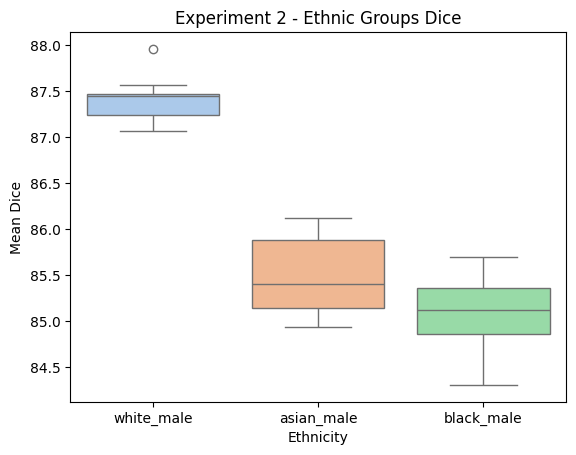

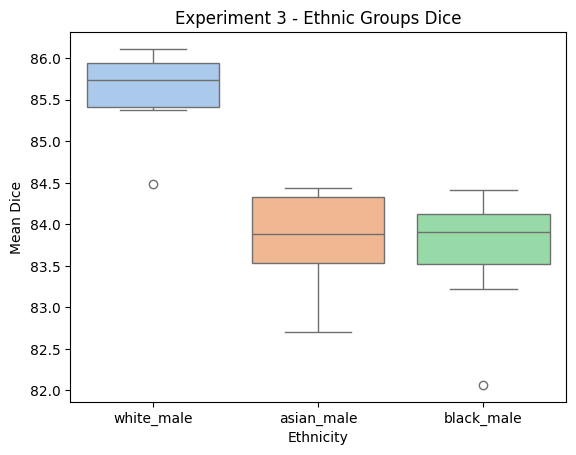

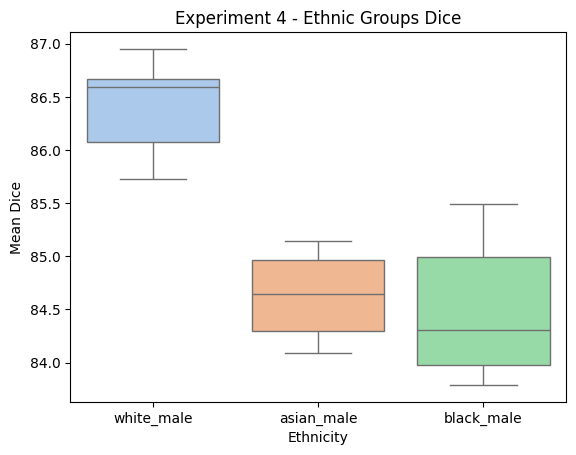

In [108]:
boxplot_ethn_dice(sex_df, '_male')

In [108]:
ethn_ttest(sex_df, '_female')

Experiment 2
-------------
t-statistic: 4.734489960934229
p-value: 0.00016547024479627163
There is a statistically significant difference (p-value < 0.05) in Dice similarity scores between experiment/group 2 white_female and 2 asian_female.

t-statistic: 6.885566381353569
p-value: 1.9356864422382192e-06
There is a statistically significant difference (p-value < 0.05) in Dice similarity scores between experiment/group 2 white_female and 2 black_female.

t-statistic: 1.0216626398318214
p-value: 0.3204764314591282
There is not sufficient evidence (p-value >= 0.05) to conclude a statistically significant difference in Dice similarity scores between experiment/group 2 asian_female and 2 black_female.

Experiment 3
-------------
t-statistic: 4.015508103713226
p-value: 0.0008113189503240652
There is a statistically significant difference (p-value < 0.05) in Dice similarity scores between experiment/group 3 white_female and 3 asian_female.

t-statistic: 3.1343318007328786
p-value: 0.0057318718

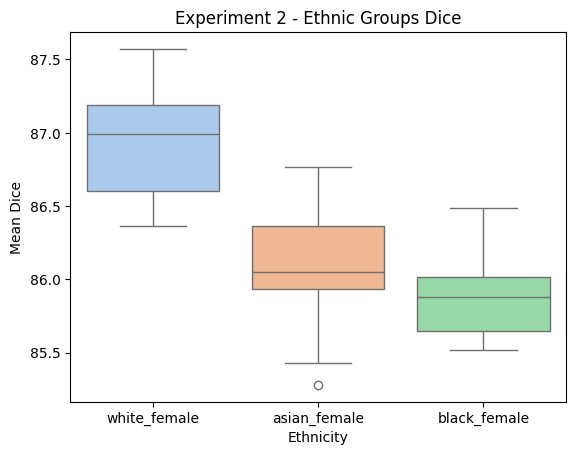

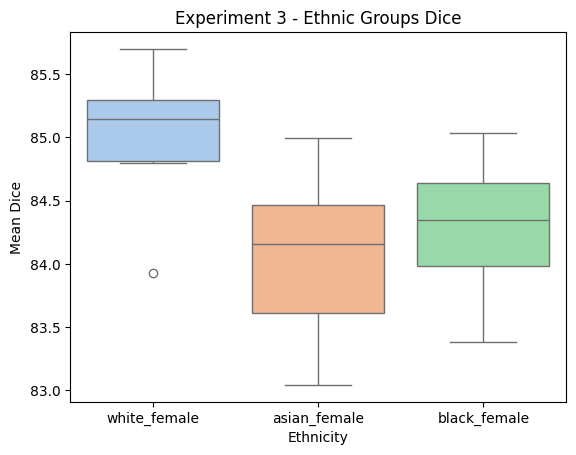

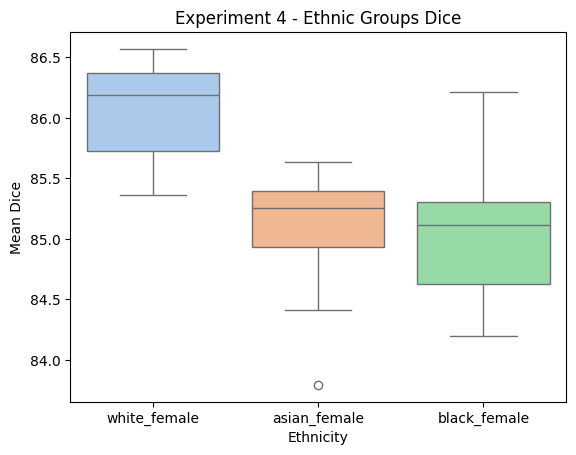

In [109]:
boxplot_ethn_dice(sex_df, '_female')

In [141]:
exps_ttest(sex_df)

Comparing dice_mean
Experiment 2 vs. 3
-------------
t-statistic: 10.289522582228173
p-value: 5.746039545780501e-09
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group 2 dice_mean and 3 dice_mean.

Experiment 2 vs. 4
-------------
t-statistic: 5.820813899687802
p-value: 1.630020750367708e-05
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group 2 dice_mean and 4 dice_mean.

Experiment 3 vs. 4
-------------
t-statistic: -4.6605658777753245
p-value: 0.0001945660493208868
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group 3 dice_mean and 4 dice_mean.

-----------------------------------------------------------------
Comparing dice_lv
Experiment 2 vs. 3
-------------
t-statistic: 7.999923782396608
p-value: 2.45105308030604e-07
There is a statistically significant difference (p-value < 0.05) in DICE sim

In [131]:
sub_ttest(sex_df)

Comparing sex groups for white ethnic group
Experiment 2
white_male vs. white_female
t-statistic: 3.0356043829411212
p-value: 0.0071122106967713185
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group 2 white_male and 2 white_female.

asian_male vs. asian_female
t-statistic: -2.7290944978263587
p-value: 0.013772589962998244
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group 2 asian_male and 2 asian_female.

black_male vs. black_female
t-statistic: -4.689950502826149
p-value: 0.00018242385348643297
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group 2 black_male and 2 black_female.

-------------
Experiment 3
white_male vs. white_female
t-statistic: 2.734890103095332
p-value: 0.013603610622862137
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between expe

UKBB Test Data - Sex Controlled -  962 Patients


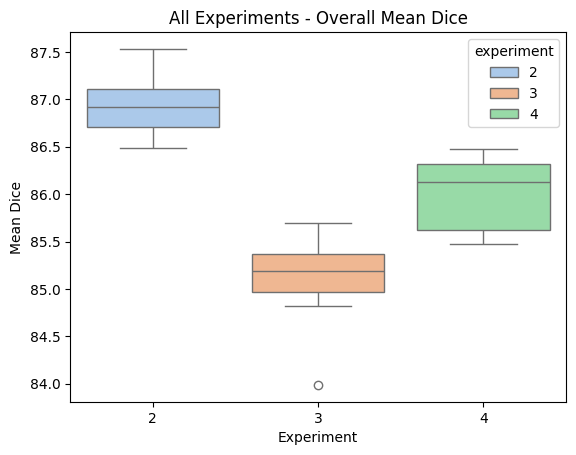

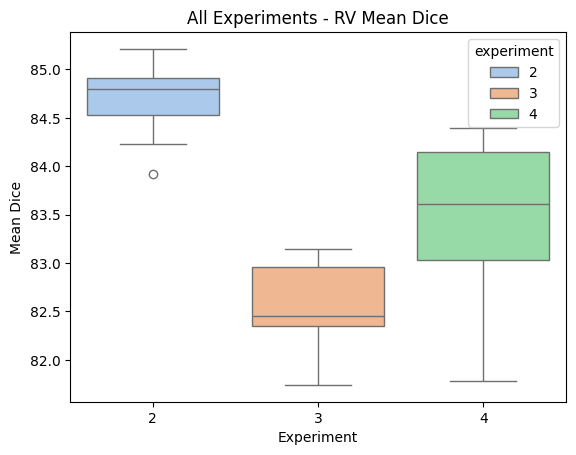

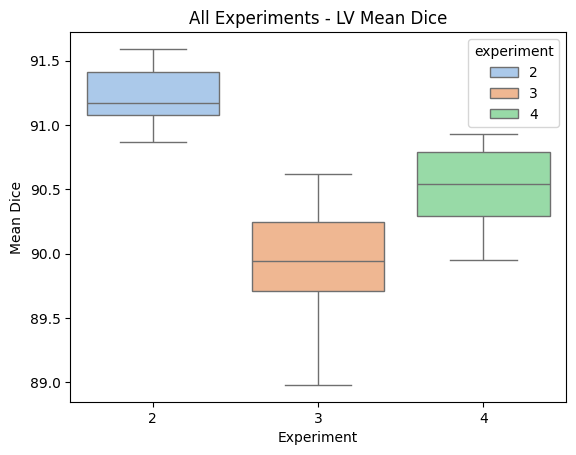

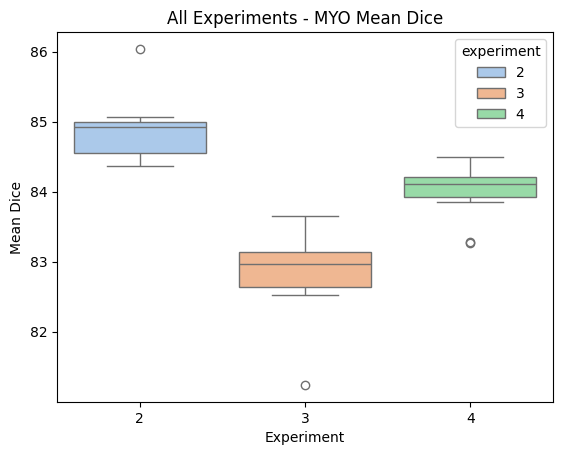

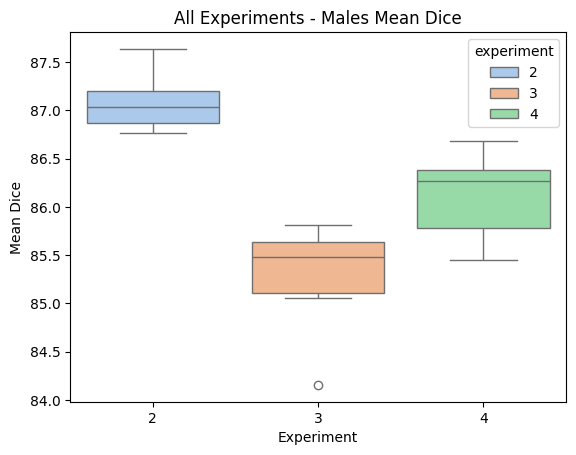

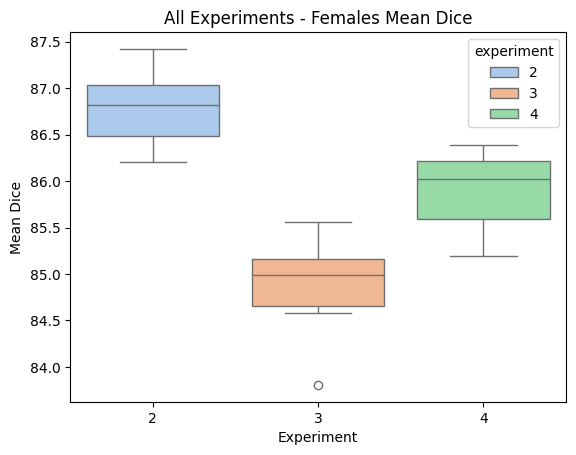

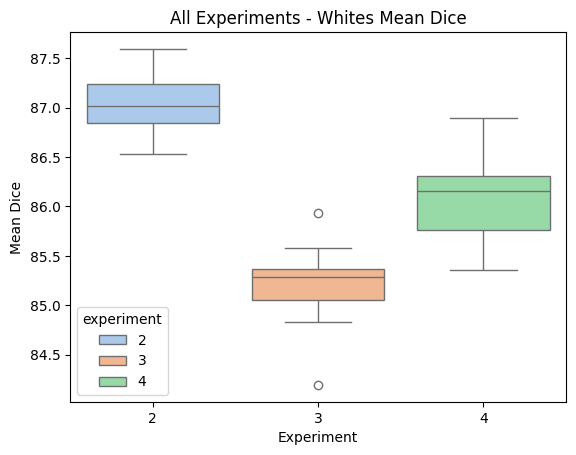

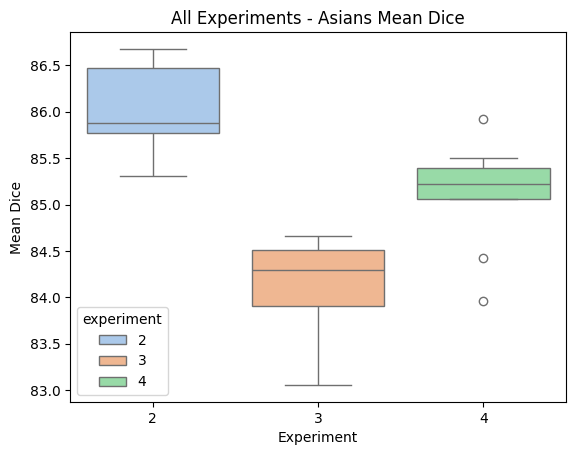

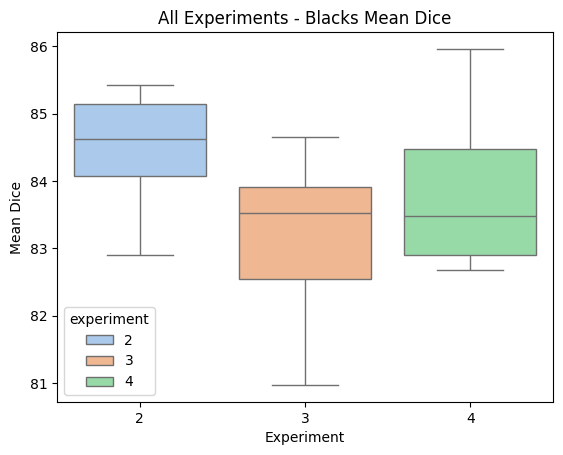

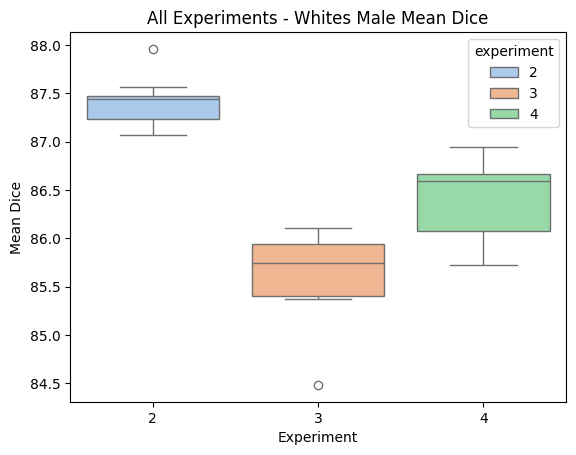

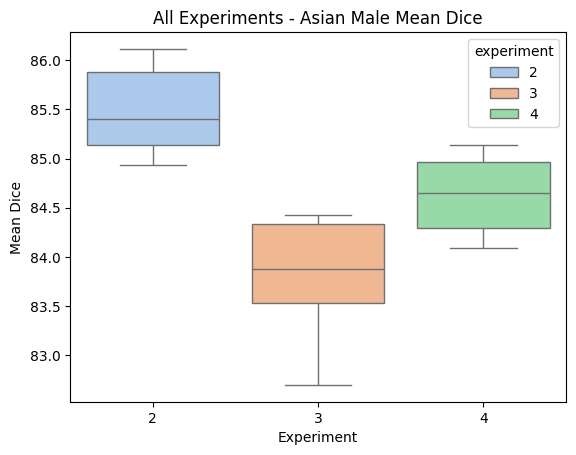

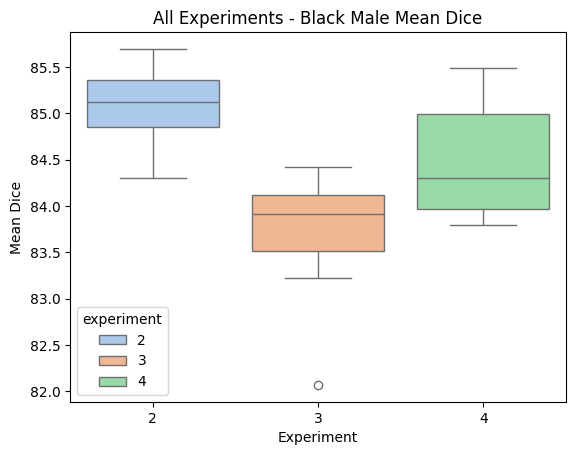

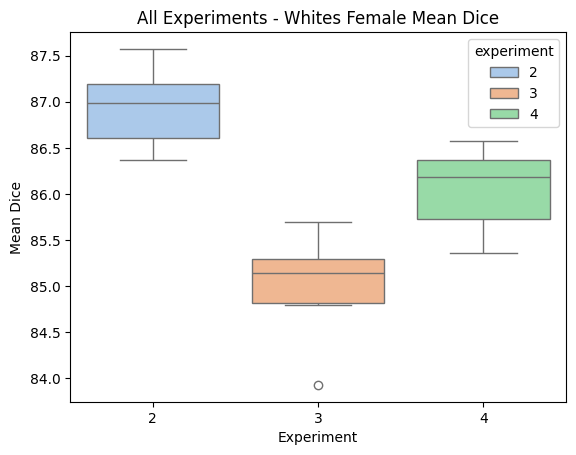

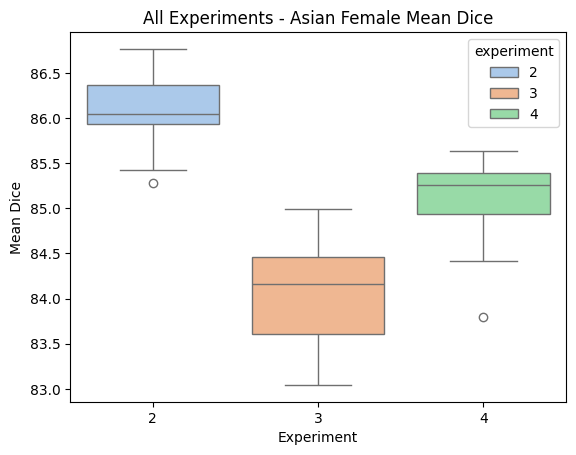

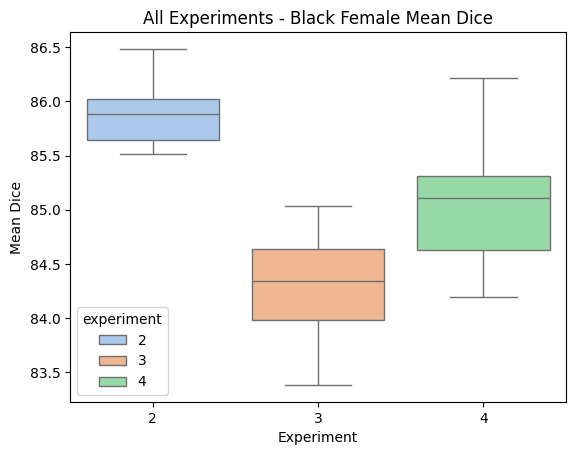

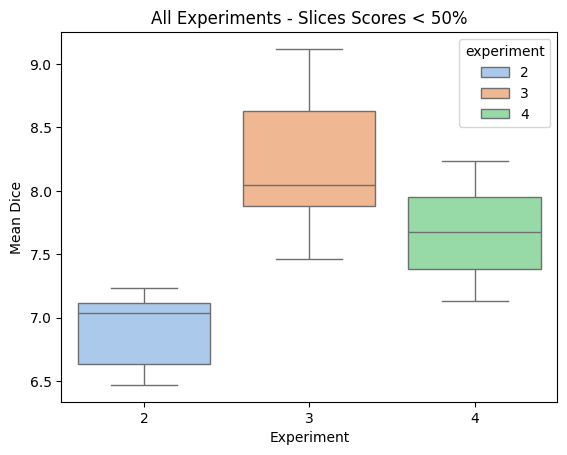

In [110]:
print(cfg['data_desc'])
plot_exps(sex_df)

## Ethnicity Controlled Test Set Results

In [79]:
ethn_df = pd.DataFrame(columns=columns)

for exp in EXPERIMENTS:
    cfg = load(open(f'configs/ukbb/test/exp{exp}/ethn.yaml', 'r'), Loader=Loader)
    for seed in SEEDS:
        test_ethn_df = pd.read_csv(f'outputs/results/csv/ukbb/exp{exp}/seed{seed}/ethn.csv')
        test_ethn_merged_df = merge_results_patients(test_ethn_df, patients_df)
        res_df = get_all_results(test_ethn_merged_df, cfg)
        ethn_df = pd.concat([ethn_df, res_df], ignore_index=True)

/tmp/ipykernel_3944/3450773364.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ethn_df = pd.concat([ethn_df, res_df], ignore_index=True)


In [80]:
ethn_df.head()

,experiment,model,train_set,test_set,dice_mean,dice_lv,dice_rv,dice_myo,male,male_lv,...,black_rv,black_lv,black_myo,white_male,asian_male,black_male,white_female,asian_female,black_female,low_scores_prcnt
0,2,unimatch unet,805,108,85.976612,90.390615,83.764734,83.774486,86.315897,90.164508,...,83.152784,90.172666,82.381140,85.855167,87.318206,85.661155,86.180186,84.894660,85.648639,7.782609
1,2,unimatch unet,805,108,86.065854,90.387592,84.305297,83.504672,86.499207,90.324506,...,82.648583,88.453917,82.593640,85.353346,87.395689,86.616797,85.618584,85.547020,85.671585,8.130435
2,2,unimatch unet,805,108,85.774362,90.279051,83.634719,83.409317,86.464309,90.721583,...,82.222029,88.842645,81.381352,86.122782,87.419656,85.746695,85.382250,85.080884,84.683652,8.608696
3,2,unimatch unet,805,108,85.869630,90.318351,83.611213,83.679328,86.453146,90.449129,...,82.044591,88.602038,83.829309,85.820667,86.996529,86.464948,85.619107,84.939882,85.155374,8.173913
4,2,unimatch unet,805,108,85.990224,90.066474,84.424179,83.480019,86.614655,90.169888,...,83.416903,91.067705,83.128247,85.632788,87.481052,86.607989,85.238344,85.089146,85.671651,7.869565


In [81]:
ethn_ttest(ethn_df)

Experiment 2
-------------
t-statistic: -2.79296856982882
p-value: 0.012016367163834875
There is a statistically significant difference (p-value < 0.05) in Dice similarity scores between white and asian groups.

Experiment 3
-------------
t-statistic: 0.5095089835655388
p-value: 0.6165852528787903
There is not sufficient evidence (p-value >= 0.05) to conclude a statistically significant difference in Dice similarity scores between white and asian groups.

Experiment 4
-------------
t-statistic: 0.07818154258994404
p-value: 0.9385461972017275
There is not sufficient evidence (p-value >= 0.05) to conclude a statistically significant difference in Dice similarity scores between white and asian groups.

Experiment 2
-------------
t-statistic: 8.397221656073635
p-value: 1.220745069522663e-07
There is a statistically significant difference (p-value < 0.05) in Dice similarity scores between white and black groups.

Experiment 3
-------------
t-statistic: 5.776315817840565
p-value: 1.787589268

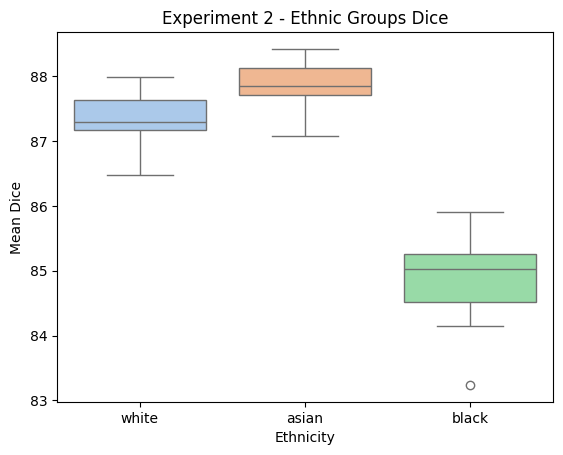

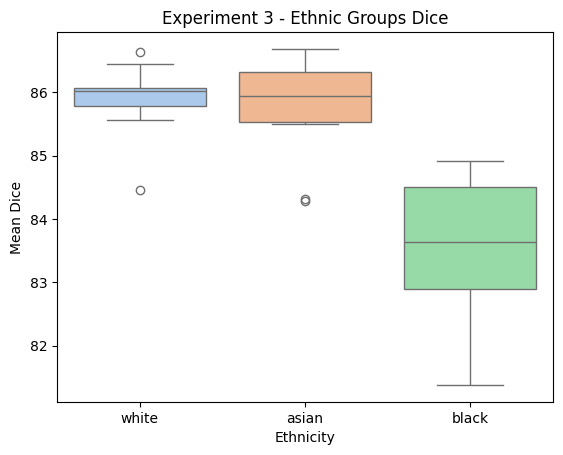

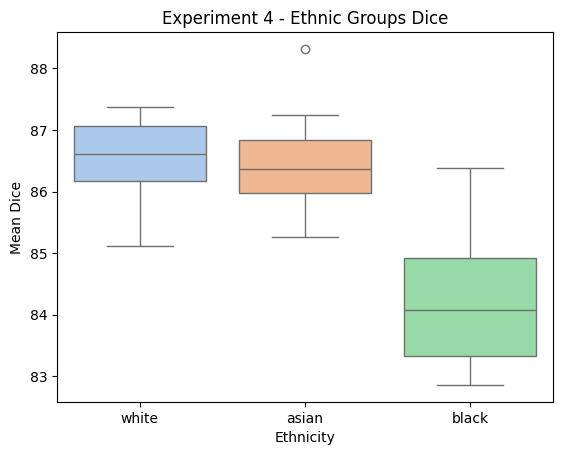

In [114]:
boxplot_ethn_dice(ethn_df)

In [82]:
ethn_ttest(ethn_df, '_rv')

Experiment 2
-------------
t-statistic: 0.9102652420818725
p-value: 0.374711409298237
There is not sufficient evidence (p-value >= 0.05) to conclude a statistically significant difference in Dice similarity scores between white_rv and asian_rv groups.

Experiment 3
-------------
t-statistic: 3.303497170033959
p-value: 0.003950689602074416
There is a statistically significant difference (p-value < 0.05) in Dice similarity scores between white_rv and asian_rv groups.

Experiment 4
-------------
t-statistic: 1.7433029388951007
p-value: 0.09833643375347075
There is not sufficient evidence (p-value >= 0.05) to conclude a statistically significant difference in Dice similarity scores between white_rv and asian_rv groups.

Experiment 2
-------------
t-statistic: 11.334343465237406
p-value: 1.2575870918755157e-09
There is a statistically significant difference (p-value < 0.05) in Dice similarity scores between white_rv and black_rv groups.

Experiment 3
-------------
t-statistic: 7.02073686875

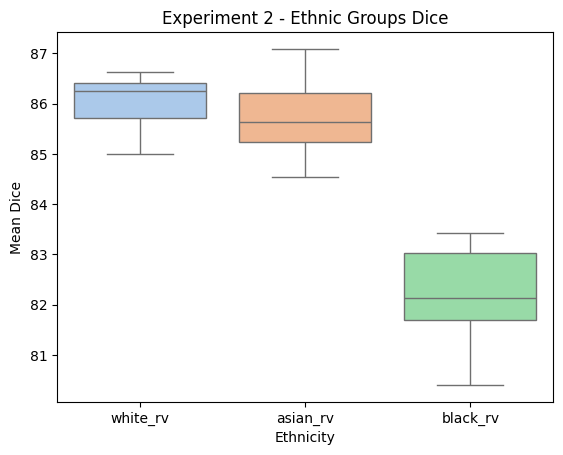

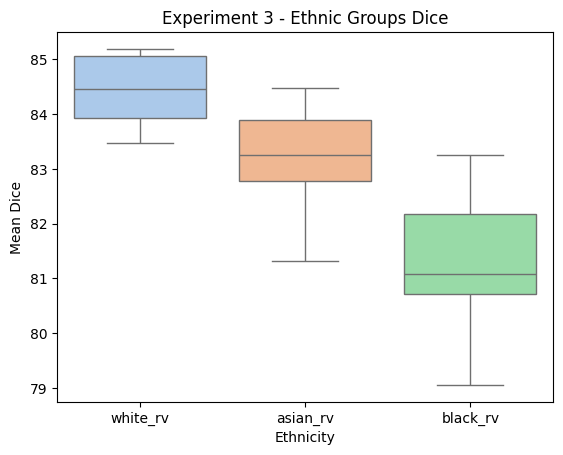

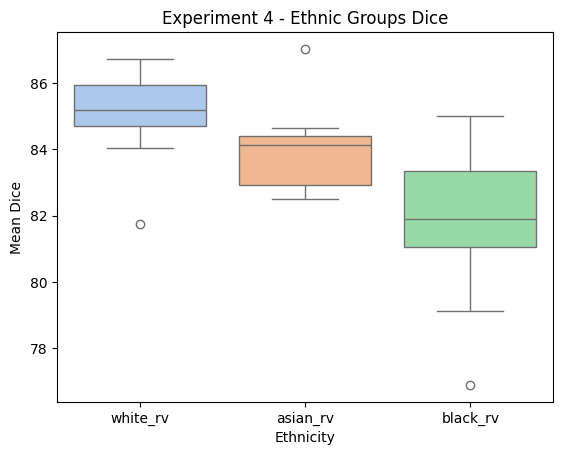

In [115]:
boxplot_ethn_dice(ethn_df, '_rv')

In [132]:
ethn_ttest(ethn_df, '_lv')

Experiment 2
-------------
t-statistic: -1.9242982767207777
p-value: 0.07027414752248093
There is not sufficient evidence (p-value >= 0.05) to conclude a statistically significant difference in DICE similarity scores between experiment/group 2 white_lv and 2 asian_lv.

t-statistic: 2.1599786602040294
p-value: 0.04450971997577973
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group 2 white_lv and 2 black_lv.

t-statistic: 3.4527577879045537
p-value: 0.00283932333379193
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group 2 asian_lv and 2 black_lv.

Experiment 3
-------------
t-statistic: -1.0765041135562556
p-value: 0.2959192132438829
There is not sufficient evidence (p-value >= 0.05) to conclude a statistically significant difference in DICE similarity scores between experiment/group 3 white_lv and 3 asian_lv.

t-statistic: 3.373038594054652
p-value: 0.003387800

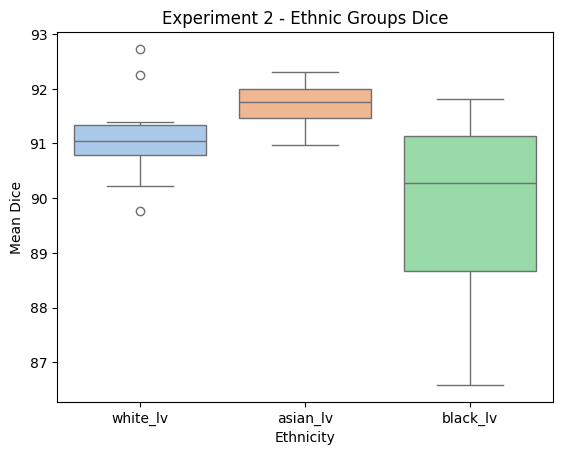

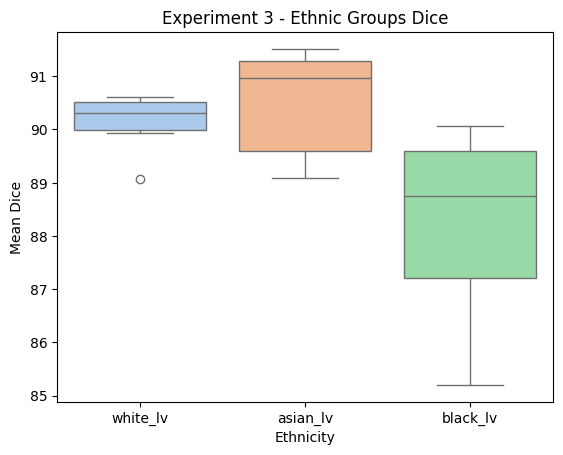

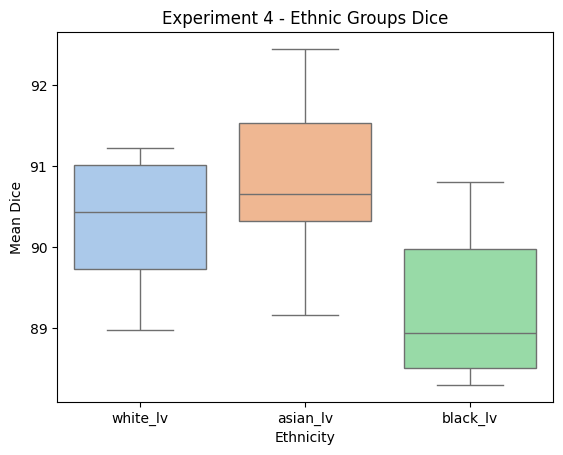

In [116]:
boxplot_ethn_dice(ethn_df, '_lv')

In [133]:
ethn_ttest(ethn_df, '_myo')

Experiment 2
-------------
t-statistic: -5.857108322610494
p-value: 1.5121218402865363e-05
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group 2 white_myo and 2 asian_myo.

t-statistic: 7.388917565461492
p-value: 7.455405201076862e-07
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group 2 white_myo and 2 black_myo.

t-statistic: 11.217135847031578
p-value: 1.483259655297045e-09
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group 2 asian_myo and 2 black_myo.

Experiment 3
-------------
t-statistic: -0.7175718936672314
p-value: 0.4822308525233501
There is not sufficient evidence (p-value >= 0.05) to conclude a statistically significant difference in DICE similarity scores between experiment/group 3 white_myo and 3 asian_myo.

t-statistic: 3.814597192742882
p-value: 0.0012694177324183706
There is a st

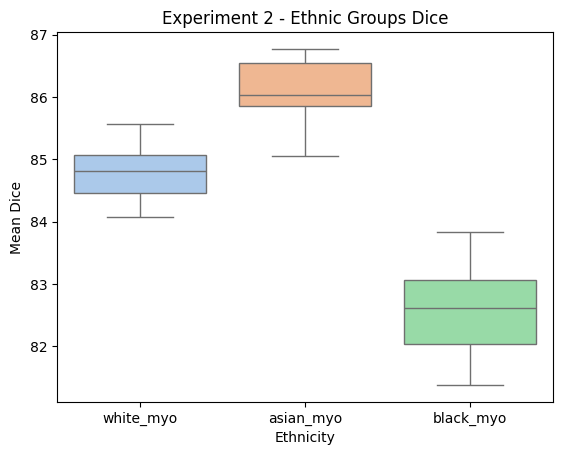

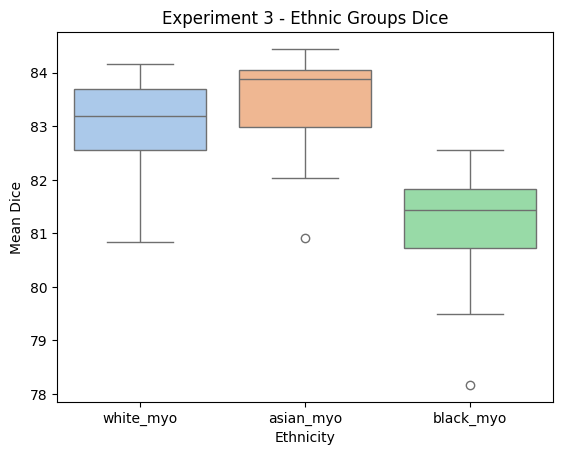

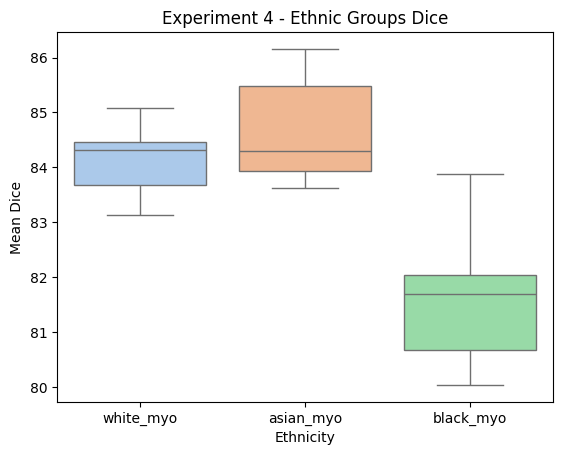

In [117]:
boxplot_ethn_dice(ethn_df, '_myo')

In [134]:
ethn_ttest(ethn_df, '_male')

Experiment 2
-------------
t-statistic: -7.126316969246854
p-value: 1.2211966674385737e-06
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group 2 white_male and 2 asian_male.

t-statistic: -2.6913262476760162
p-value: 0.014923945448122098
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group 2 white_male and 2 black_male.

t-statistic: 4.242343235184418
p-value: 0.0004899182676654508
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group 2 asian_male and 2 black_male.

Experiment 3
-------------
t-statistic: -2.9031054616994694
p-value: 0.009481580053651349
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group 3 white_male and 3 asian_male.

t-statistic: -2.5623797389633154
p-value: 0.01958583742076204
There is a statistically significant dif

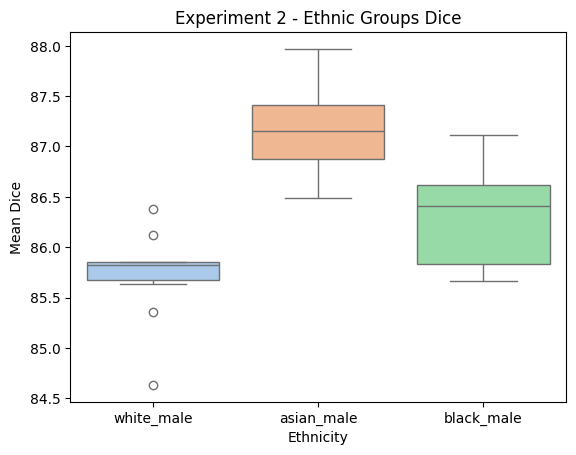

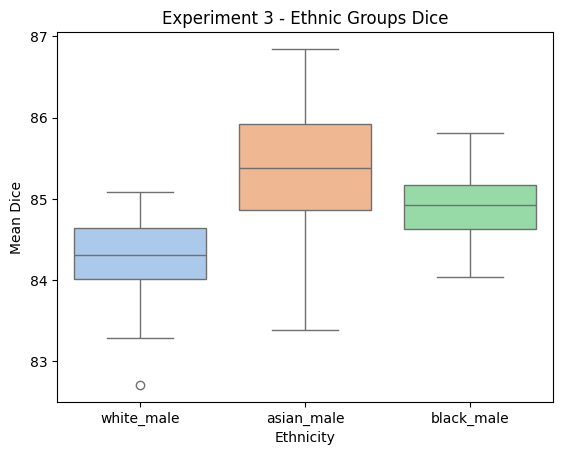

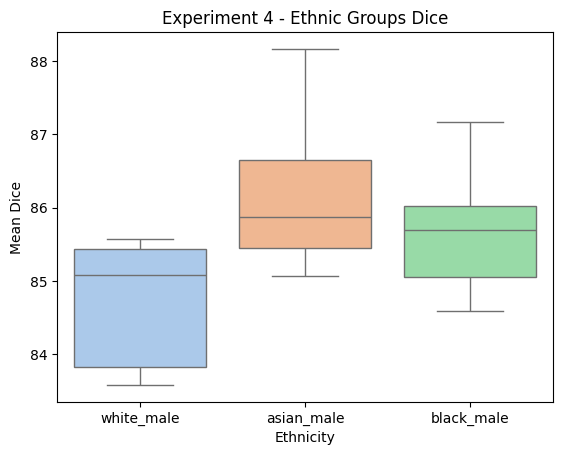

In [120]:
boxplot_ethn_dice(ethn_df, '_male')

In [135]:
ethn_ttest(ethn_df, '_female')

Experiment 2
-------------
t-statistic: 1.359578878268808
p-value: 0.1907524641840294
There is not sufficient evidence (p-value >= 0.05) to conclude a statistically significant difference in DICE similarity scores between experiment/group 2 white_female and 2 asian_female.

t-statistic: 0.18564865068469327
p-value: 0.8547963016877128
There is not sufficient evidence (p-value >= 0.05) to conclude a statistically significant difference in DICE similarity scores between experiment/group 2 white_female and 2 black_female.

t-statistic: -1.4402615640669267
p-value: 0.16696103604866414
There is not sufficient evidence (p-value >= 0.05) to conclude a statistically significant difference in DICE similarity scores between experiment/group 2 asian_female and 2 black_female.

Experiment 3
-------------
t-statistic: 3.6069386115539683
p-value: 0.0020158417762098035
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group 3 white_female and

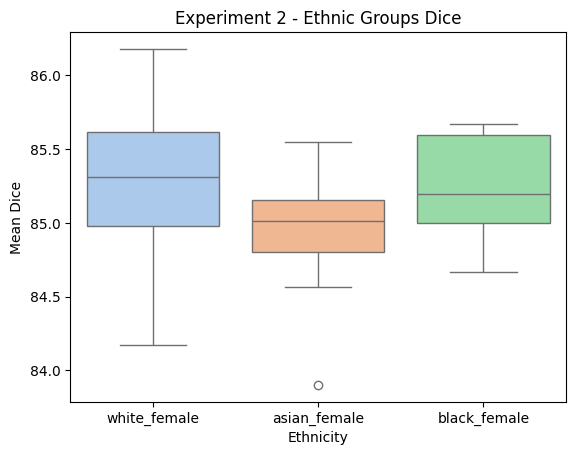

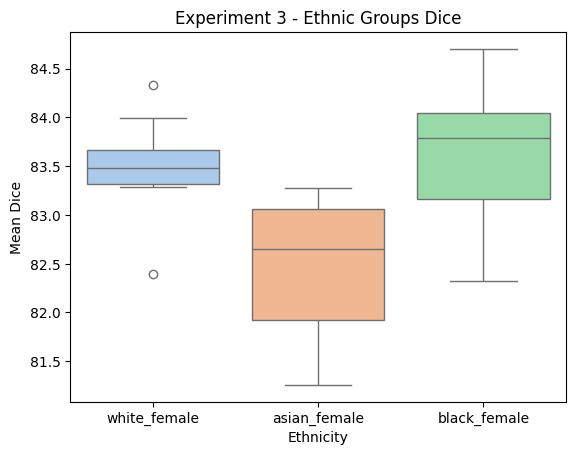

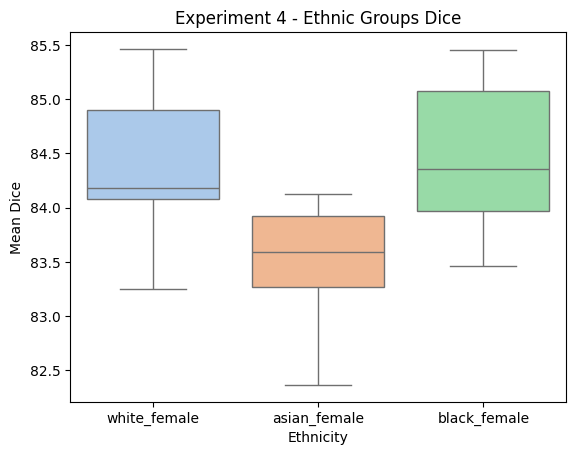

In [121]:
boxplot_ethn_dice(ethn_df, '_female')

In [136]:
sex_ttest(ethn_df)

Experiment 2
-------------
t-statistic: 8.20733925134541
p-value: 1.6990497336432572e-07
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group 2 male and 2 female.

Experiment 3
-------------
t-statistic: 5.780281403873183
p-value: 1.772931647246636e-05
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group 3 male and 3 female.

Experiment 4
-------------
t-statistic: 4.34423672368258
p-value: 0.0003908437220885042
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group 4 male and 4 female.



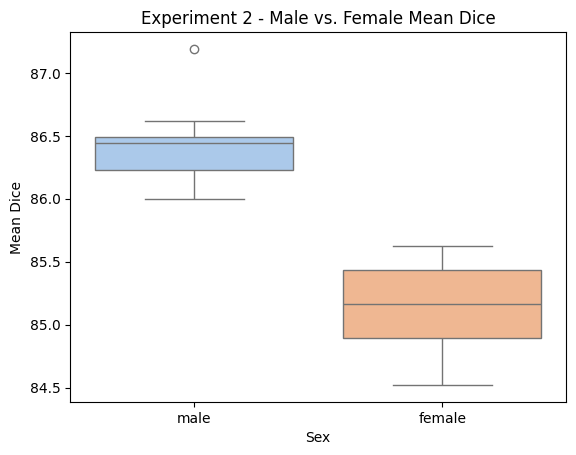

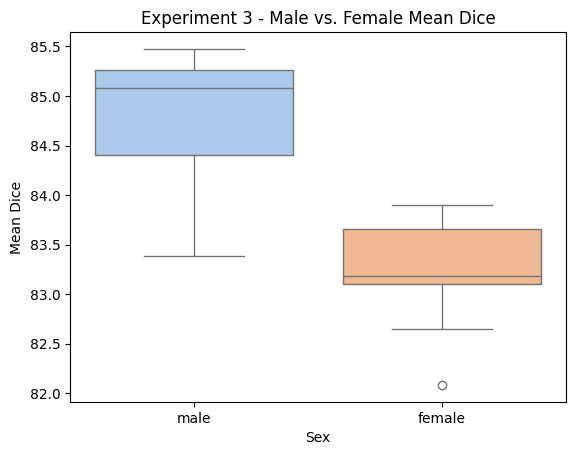

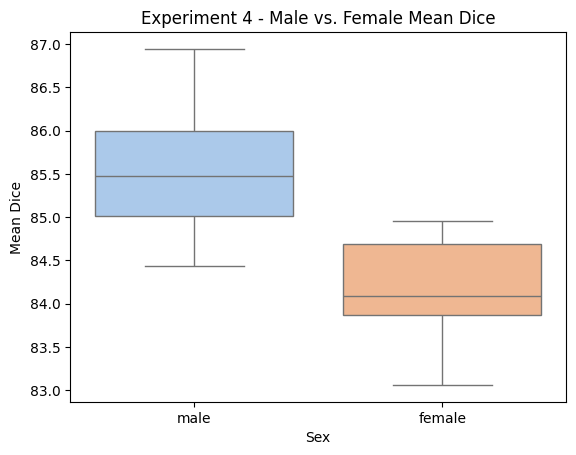

In [122]:
boxplot_sex_dice(ethn_df)

In [137]:
sex_ttest(ethn_df, '_rv')

Experiment 2
-------------
t-statistic: 6.395261351258576
p-value: 5.067612162559476e-06
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group 2 male_rv and 2 female_rv.

Experiment 3
-------------
t-statistic: 5.345133718487618
p-value: 4.425930676374538e-05
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group 3 male_rv and 3 female_rv.

Experiment 4
-------------
t-statistic: 1.8281519724263953
p-value: 0.08414963490539404
There is not sufficient evidence (p-value >= 0.05) to conclude a statistically significant difference in DICE similarity scores between experiment/group 4 male_rv and 4 female_rv.



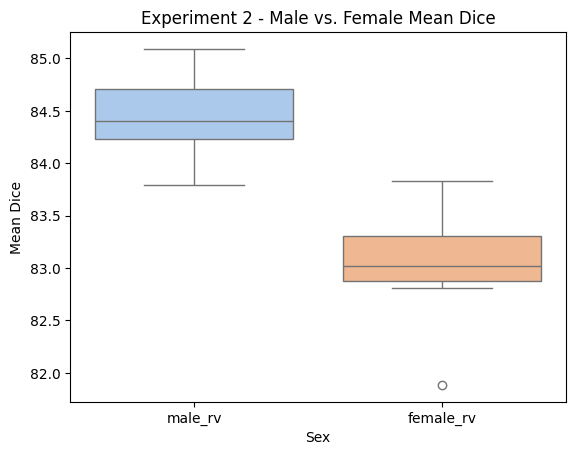

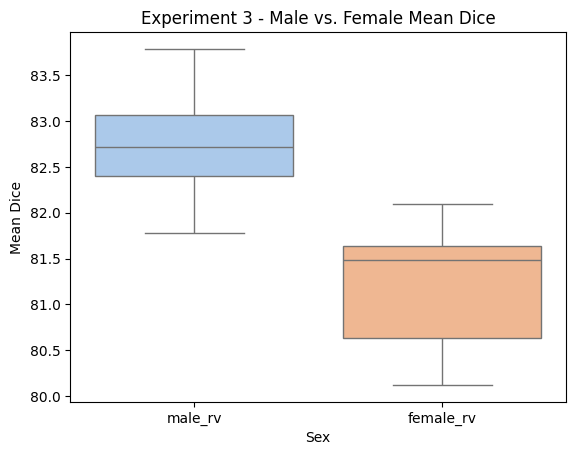

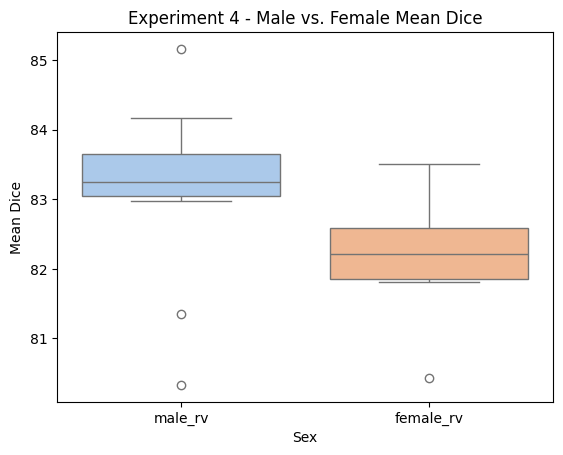

In [123]:
boxplot_sex_dice(ethn_df, '_rv')

In [138]:
sex_ttest(ethn_df, '_lv')

Experiment 2
-------------
t-statistic: 1.9547757317666696
p-value: 0.0663212466752574
There is not sufficient evidence (p-value >= 0.05) to conclude a statistically significant difference in DICE similarity scores between experiment/group 2 male_lv and 2 female_lv.

Experiment 3
-------------
t-statistic: 2.4715284938895263
p-value: 0.02366568514405716
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group 3 male_lv and 3 female_lv.

Experiment 4
-------------
t-statistic: 2.1121124940927505
p-value: 0.04891454446202155
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group 4 male_lv and 4 female_lv.



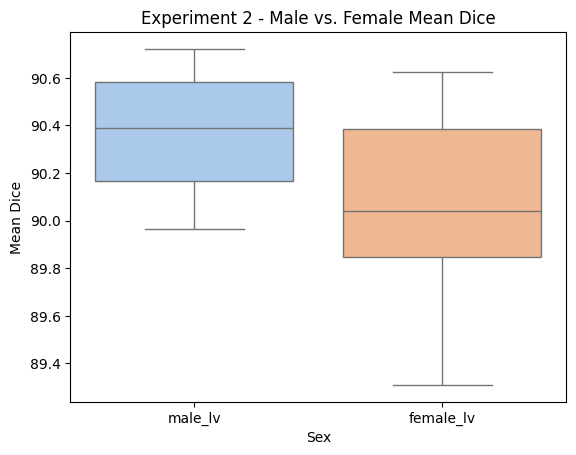

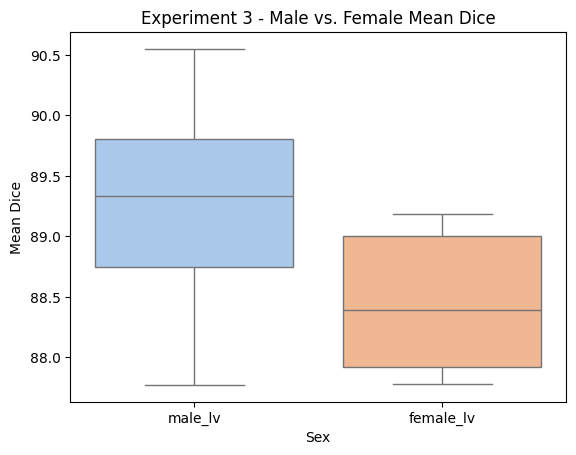

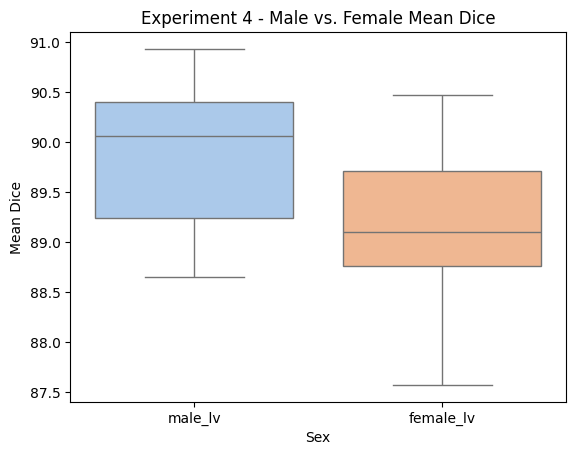

In [124]:
boxplot_sex_dice(ethn_df, '_lv')

In [139]:
sex_ttest(ethn_df, '_myo')

Experiment 2
-------------
t-statistic: 8.134863883924469
p-value: 1.929921946568292e-07
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group 2 male_myo and 2 female_myo.

Experiment 3
-------------
t-statistic: 7.013850334139013
p-value: 1.5129104621970366e-06
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group 3 male_myo and 3 female_myo.

Experiment 4
-------------
t-statistic: 7.84349033124467
p-value: 3.243362726798891e-07
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group 4 male_myo and 4 female_myo.



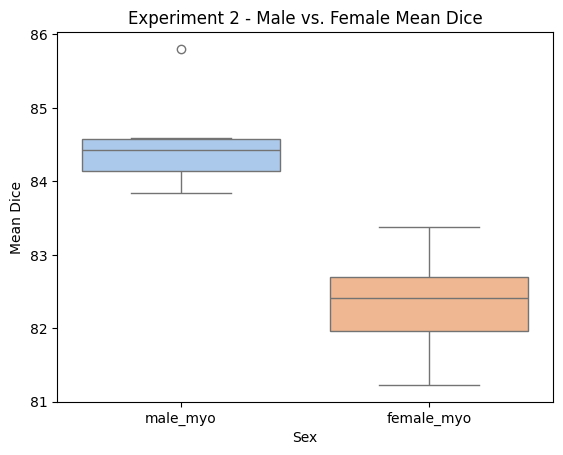

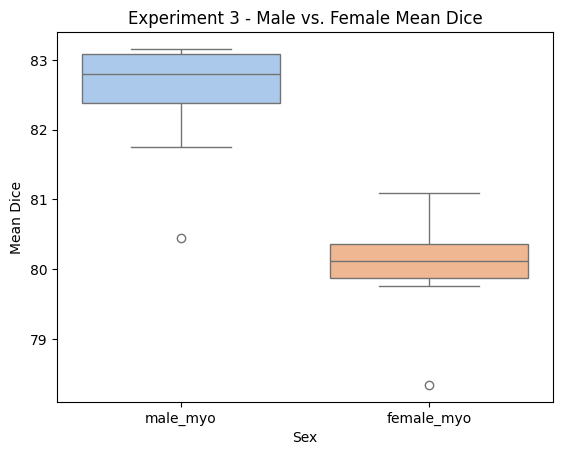

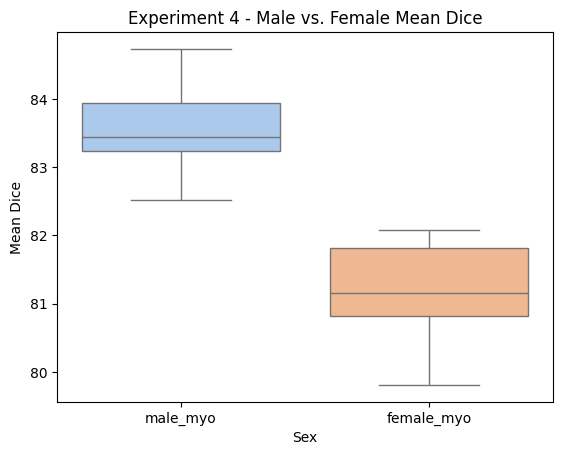

In [125]:
boxplot_sex_dice(ethn_df, '_myo')

UKBB Test Data - Ethnicity Controlled -  108 Patients


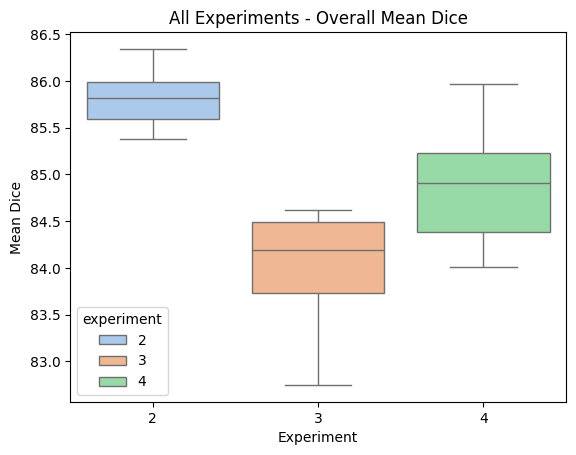

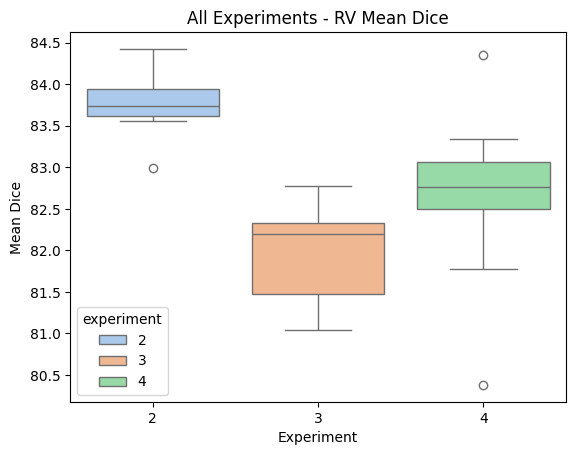

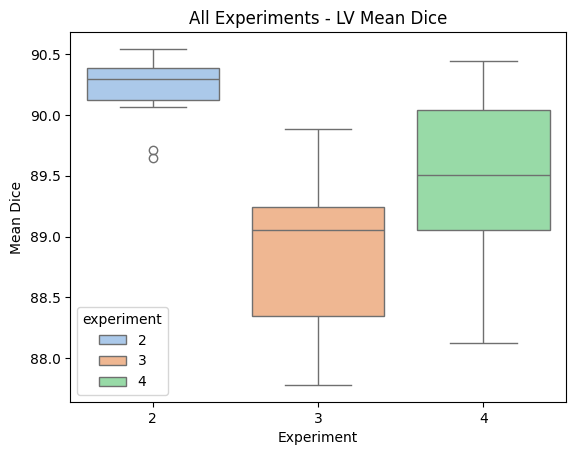

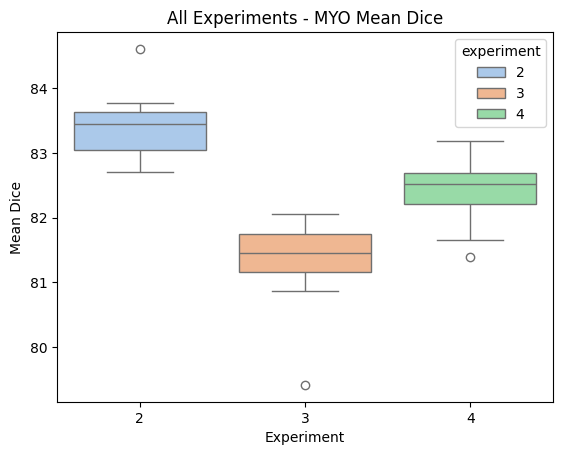

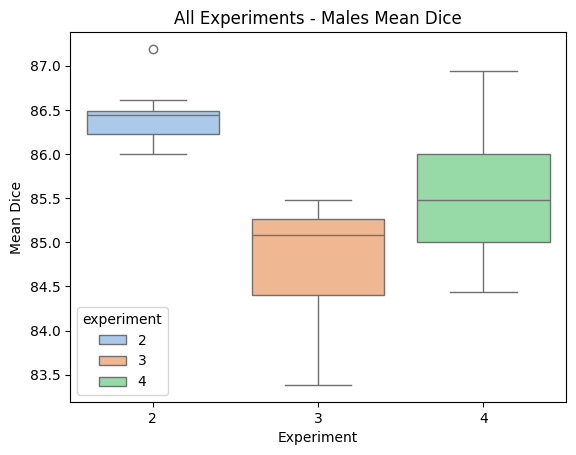

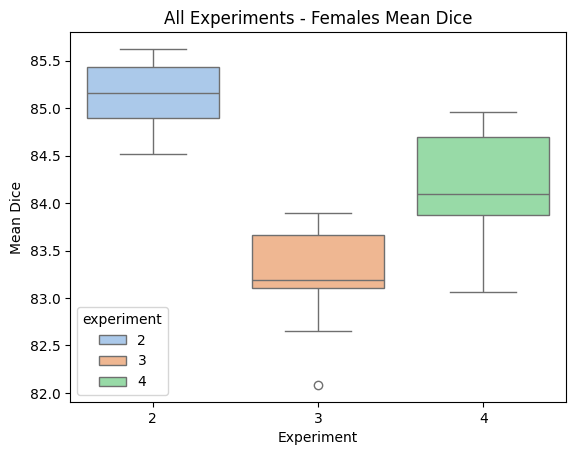

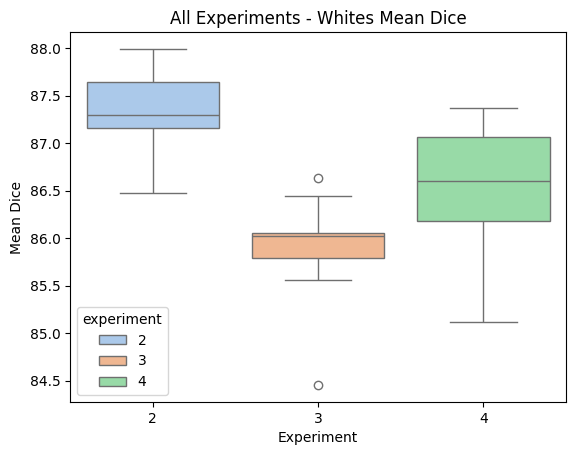

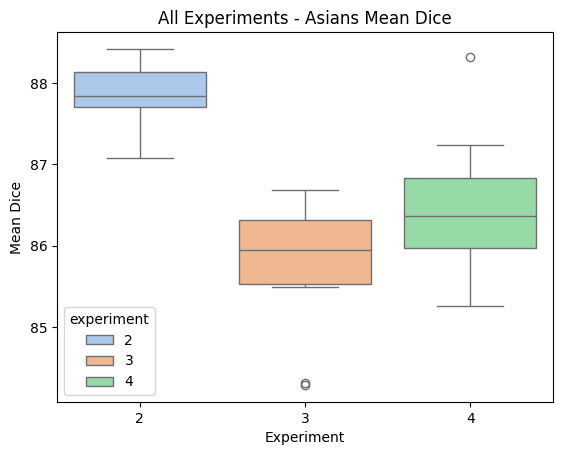

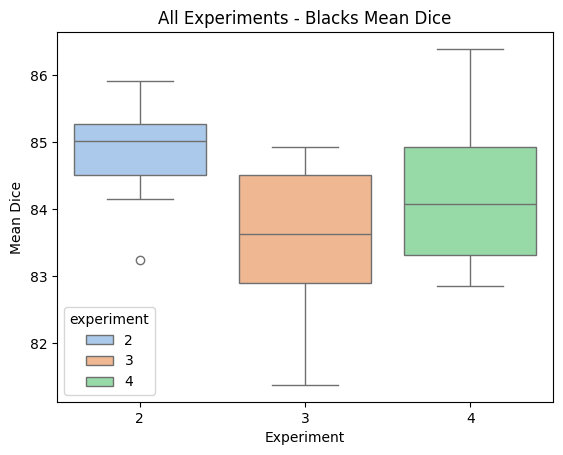

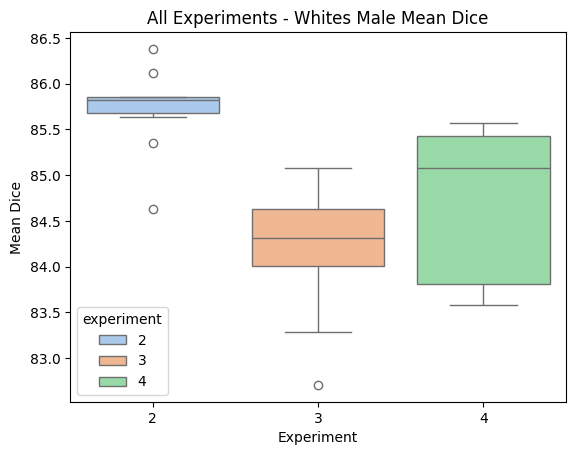

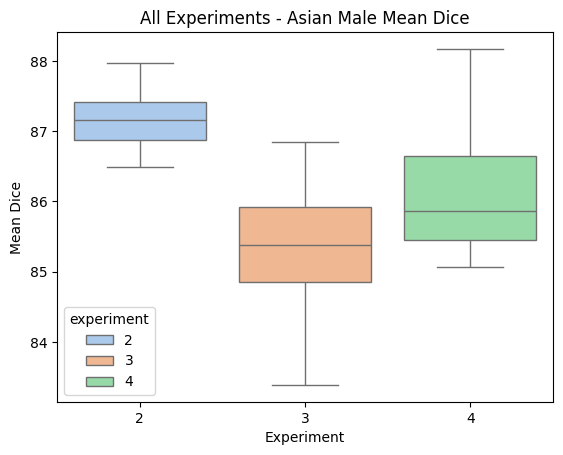

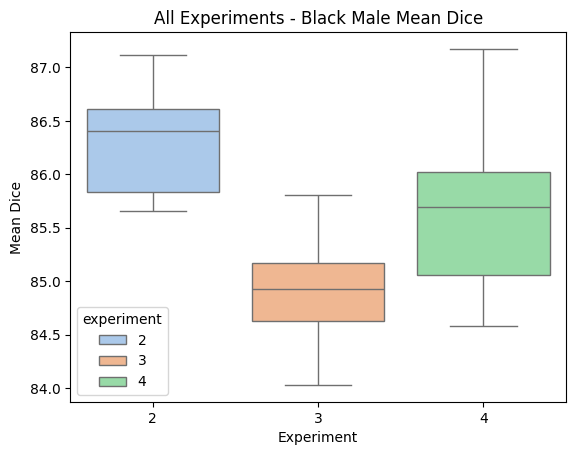

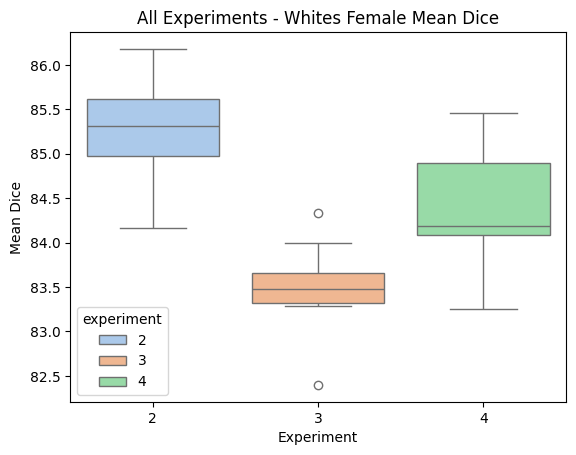

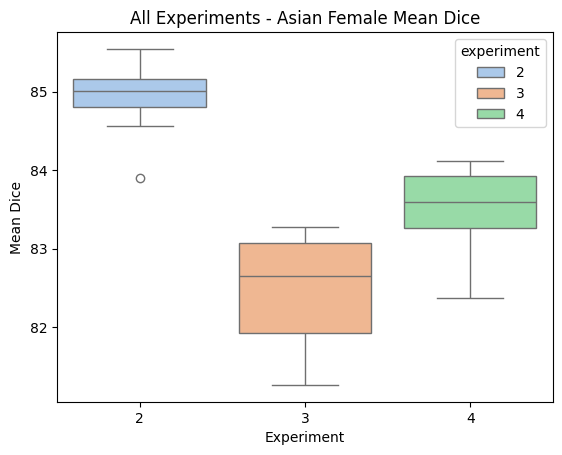

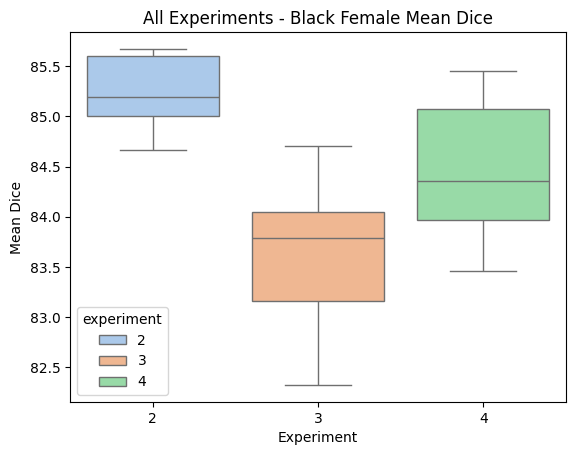

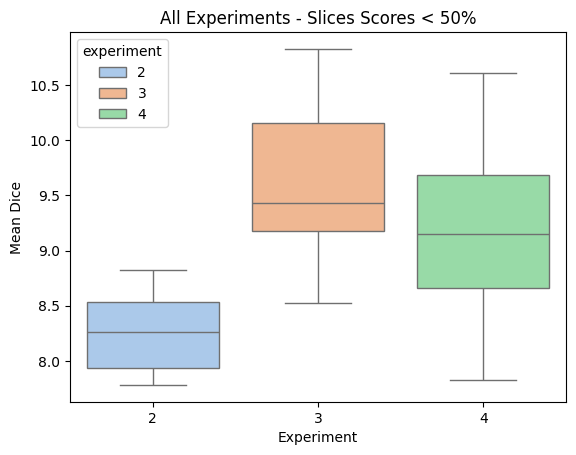

In [126]:
print(cfg['data_desc'])
plot_exps(ethn_df)

In [142]:
exps_ttest(ethn_df)

Comparing dice_mean
Experiment 2 vs. 3
-------------
t-statistic: 8.441747891201878
p-value: 1.1304342353376626e-07
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group 2 dice_mean and 3 dice_mean.

Experiment 2 vs. 4
-------------
t-statistic: 4.434223666339953
p-value: 0.00032029044685232477
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group 2 dice_mean and 4 dice_mean.

Experiment 3 vs. 4
-------------
t-statistic: -3.0568517552088097
p-value: 0.006790182734217386
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group 3 dice_mean and 4 dice_mean.

-----------------------------------------------------------------
Comparing dice_lv
Experiment 2 vs. 3
-------------
t-statistic: 5.872954704318698
p-value: 1.4634346524156956e-05
There is a statistically significant difference (p-value < 0.05) in DICE s

In [143]:
sub_ttest(ethn_df)

Experiment 2
white_male vs. white_female
t-statistic: 3.0356043829411212
p-value: 0.0071122106967713185
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group 2 white_male and 2 white_female.

asian_male vs. asian_female
t-statistic: -2.7290944978263587
p-value: 0.013772589962998244
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group 2 asian_male and 2 asian_female.

black_male vs. black_female
t-statistic: -4.689950502826149
p-value: 0.00018242385348643297
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group 2 black_male and 2 black_female.

-------------
Experiment 3
white_male vs. white_female
t-statistic: 2.734890103095332
p-value: 0.013603610622862137
There is a statistically significant difference (p-value < 0.05) in DICE similarity scores between experiment/group 3 white_male and 3 white_female